# В данном ноутбуке я уже применю модель вида ARIMA для другой ценной бумаги (`GAZP`)

### Импорт библиотек

In [3]:
# Базовые библиотеки и утилиты
import numpy as np
import pandas as pd
import datetime
import os
import time
import time as time_module
import warnings
from copy import deepcopy
from bisect import bisect_left
from itertools import product
from typing import Union, Optional

# Настройки pandas
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', None)

# Отображение в Jupyter
from IPython.display import display
%matplotlib inline

# Визуализация
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from utilsforecast.plotting import plot_series

# Работа с календарём
import holidays

# Прогресс-бары
from tqdm import tqdm

# SciPy
import scipy as sp
from scipy import stats
from scipy.stats import ttest_1samp, shapiro, ks_2samp, zscore
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform

# Statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.datasets import longley
from statsmodels.formula.api import ols
from statsmodels.graphics import tsaplots
from statsmodels.graphics.gofplots import qqplot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox, het_breuschpagan
from statsmodels.tsa.stattools import acf, adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.ar_model import ar_select_order
from statsmodels.tsa.arima.model import ARIMA

# StatsForecast
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, _TS

# Scikit-learn: модели, препроцессинг, метрики
from sklearn.cluster import DBSCAN
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    f1_score, mean_absolute_error, mean_squared_error, precision_score,
    r2_score, recall_score, roc_auc_score, roc_curve
)
from sklearn.model_selection import (
    GridSearchCV, ParameterGrid, RandomizedSearchCV,
    TimeSeriesSplit, train_test_split
)
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.tree import DecisionTreeClassifier

# Boosting модели
from catboost import CatBoostRegressor
import catboost as cb
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier, XGBRegressor
import xgboost as xgb

# Гиперпараметрический поиск
from hyperopt import fmin, tpe, Trials, STATUS_OK, hp

# Кодировщики категориальных признаков
import category_encoders as ce

# Дополнительные утилиты
from sktime.utils.plotting import plot_correlations

# SHAP
import shap

### Ряд используемых функций

In [5]:
def plot_forecast_with_dates(y_train, y_test, forecast, df, title="Прогноз vs Истина", label="Прогноз"):
    fact_color = "#244b8c"
    pred_color = "#c72c2c"
    split_color = "#22bb33"

    # Даты для оси X
    dates_train = df['ds'].iloc[:len(y_train)]
    dates_test = df['ds'].iloc[len(y_train):len(y_train) + len(y_test)]

    # Собираем общий временной ряд
    all_dates = np.concatenate([dates_train, dates_test])
    all_actual = np.concatenate([y_train, y_test])
    all_predictions = np.concatenate([np.full(len(y_train), np.nan), forecast])

    plt.figure(figsize=(14, 7))

    # Сетка - очень светлая, на заднем плане
    plt.grid(True, which='major', color='#cccccc', linewidth=1, zorder=0)

    # Реальные значения: яркая синяя линия, поверх сетки
    plt.plot(
        all_dates, all_actual,
        color=fact_color,
        linewidth=1.7,
        alpha=1.0,
        label='Реальные значения',
        zorder=2
    )

    # Прогноз: красный пунктир, поверх синей
    plt.plot(
        all_dates, all_predictions,
        color=pred_color,
        linewidth=1.9,
        linestyle='--',
        alpha=0.95,
        label=label,
        zorder=3
    )

    # Вертикальная линия: ярко-зелёная, ещё выше по слоям
    plt.axvline(
        x=dates_test.iloc[0],
        color=split_color,
        linestyle='--',
        linewidth=2.1,
        label='Граница тест/трейн',
        zorder=4
    )

    plt.title(title, fontweight='bold')
    plt.xlabel('Дата')
    plt.ylabel('Значение')
    plt.legend(loc='upper left', frameon=True, framealpha=1, edgecolor='#cccccc')
    plt.tight_layout()
    plt.show()

In [6]:
def adf_test(timeseries, alpha=0.05):
    """
    Augmented Dickey-Fuller Test with выводом интерпретации результата.
    """
    print("ADF Test (Augmented Dickey-Fuller)")
    print("H0: Временной ряд нестационарен (есть единичный корень)")
    print("H1: Временной ряд стационарен\n")
    
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '# Lags Used', 'Number of Observations Used'])

    for key, value in dftest[4].items():
        dfoutput[f'Critical Value ({key})'] = value

    print(dfoutput)
    
    print("\nИнтерпретация:")
    if dftest[1] < alpha:
        print(f"p-value = {dftest[1]:.4f} < {alpha} => Отклоняем H0: ряд считается стационарным.")
    else:
        print(f"p-value = {dftest[1]:.4f} >= {alpha} => Не отклоняем H0: ряд считается нестационарным.")
    

def kpss_test(timeseries, alpha=0.05, regression='c'):
    """
    KPSS Test с интерпретацией результата.
    regression='c' - проверка на стационарность относительно уровня
    regression='ct' - проверка на стационарность относительно тренда
    """
    print(f"KPSS Test (regression='{regression}')")
    print("H0: Временной ряд тренд-стационарен")
    print("H1: Временной ряд тренд-нестационарен\n")
    
    kpsstest = kpss(timeseries, regression=regression, nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic', 'p-value', 'Lags Used'])

    for key, value in kpsstest[3].items():
        kpss_output[f'Critical Value ({key})'] = value

    print(kpss_output)

    print("\nИнтерпретация:")
    if kpsstest[1] < alpha:
        print(f"p-value = {kpsstest[1]:.4f} < {alpha} => Отклоняем H0: ряд считается тренд-нестационарным.")
    else:
        print(f"p-value = {kpsstest[1]:.4f} ≥ {alpha} => Не отклоняем H0: ряд считается тренд-стационарным.")


def metrics_report(y_true, y_pred, seasonality=1, model_name='Модель'):
    """
    Отчёт по метрикам качества прогноза модели.

    Выводит:
    - Таблицу с основными метриками (локализовано)
    - Визуализацию в виде таблицы без цветовой иерархии

    :param y_true: Истинные значения
    :param y_pred: Предсказания модели
    :param seasonality: Сезонность (для MASE)
    :param model_name: Название модели (для заголовка)
    :return: pd.DataFrame с метриками
    """

    # Приводим данные к Series без индексов
    y_true = pd.Series(y_true).reset_index(drop=True)
    y_pred = pd.Series(y_pred).reset_index(drop=True)

    # Метрики
    def mase(y_true, y_pred, seasonality=1):
        naive = y_true.shift(seasonality)
        mask = ~naive.isna()
        naive_mae = np.mean(np.abs(y_true[mask] - naive[mask]))
        model_mae = np.mean(np.abs(y_true[mask] - y_pred[mask]))
        return model_mae / naive_mae if naive_mae != 0 else np.nan

    def smape(y_true, y_pred):
        denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
        mask = denominator != 0
        return np.mean(np.abs(y_true[mask] - y_pred[mask]) / denominator[mask]) * 100

    def mdape(y_true, y_pred):
        mask = y_true != 0
        return np.median(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

    def mape(y_true, y_pred):
        mask = y_true != 0
        return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

    # Формируем таблицу метрик
    metrics = [
        ['MAE', mean_absolute_error(y_true, y_pred)],
        ['MSE', mean_squared_error(y_true, y_pred)],
        ['RMSE', np.sqrt(mean_squared_error(y_true, y_pred))],
        ['MAPE (%)', mape(y_true, y_pred)],
        ['MDAPE (%)', mdape(y_true, y_pred)],
        ['SMAPE (%)', smape(y_true, y_pred)],
        ['R2', r2_score(y_true, y_pred)],
        ['MASE', mase(y_true, y_pred, seasonality=seasonality)]
    ]

    df = pd.DataFrame(metrics, columns=['Метрика', 'Значение'])
    df['Значение'] = df['Значение'].round(4)

    # Визуализация таблицы
    fig, ax = plt.subplots(figsize=(5, len(df) * 0.5 + 1))
    ax.axis('off')

    table = ax.table(
        cellText=df.values,
        colLabels=df.columns,
        cellLoc='center',
        loc='center'
    )

    # Настройка шрифта
    table.auto_set_font_size(False)
    table.set_fontsize(10)

    # Стиль
    for (row, col), cell in table.get_celld().items():
        if row == 0:
            cell.set_text_props(weight='bold')
            cell.set_facecolor('#f0f0f0')
        elif col == 1:
            cell.set_text_props(weight='bold', color='black')

    plt.tight_layout()
    plt.show()

    return df

def plotly_single_feature(
    df,
    column,
    index_col='ds',
    title=None,
    yaxis_title='Значение',
    line_name=None,
    color='#636EFA',
    show_mean=True,
    show_median=True,
    save=False,
    save_path='feature_plot.html'
):
    """
    Универсальный график временного ряда с возможностью отобразить среднее и медиану.

    Параметры:
    - df: DataFrame с данными
    - column: имя числового столбца для отображения
    - index_col: колонка с временным индексом (по умолчанию 'ds')
    - title: заголовок графика
    - yaxis_title: подпись оси Y
    - line_name: имя основного ряда (по умолчанию = column)
    - color: цвет линии (по умолчанию Plotly синий)
    - show_mean: показать линию среднего
    - show_median: показать линию медианы
    - save: сохранить график в HTML
    - save_path: путь к файлу (если save=True)
    """
    df = df.copy()

    if index_col in df.columns:
        df = df.set_index(index_col)

    line_name = line_name or column
    title = title or f'График: {column}'

    mean_val = df[column].mean()
    median_val = df[column].median()

    traces = []

    # Основная линия
    traces.append(go.Scatter(
        x=df.index,
        y=df[column],
        mode='lines',
        name=line_name,
        line=dict(color=color, width=2)
    ))

    # Медиана
    if show_median:
        traces.append(go.Scatter(
            x=[df.index.min(), df.index.max()],
            y=[median_val, median_val],
            mode='lines',
            name='Медиана',
            line=dict(color='orange', width=2, dash='dash')
        ))

    # Среднее
    if show_mean:
        traces.append(go.Scatter(
            x=[df.index.min(), df.index.max()],
            y=[mean_val, mean_val],
            mode='lines',
            name='Среднее',
            line=dict(color='blue', width=2, dash='dot')
        ))

    layout = go.Layout(
        title=title,
        xaxis=dict(title='Дата'),
        yaxis=dict(title=yaxis_title),
        template='plotly_white',
        hovermode='x unified',
        legend=dict(
            title='Легенда',
            orientation='v',
            x=1.02,
            y=1,
            xanchor='left',
            yanchor='top',
            bgcolor='rgba(255,255,255,0.8)',
            bordercolor='lightgray',
            borderwidth=1
        )
    )

    fig = go.Figure(data=traces, layout=layout)
    iplot(fig)

    if save:
        dir_to_save = os.path.dirname(save_path)
        if dir_to_save:
            os.makedirs(dir_to_save, exist_ok=True)
        plot(fig, filename=save_path, auto_open=False)
        print(f'Сохранено в файл: {os.path.abspath(save_path)}')

def split_train_test(df, train_ratio, target_col='y_diff', original_target_col='y', sort_by=None):
    """
    Делит датафрейм на обучающую и тестовую выборки.
    Сохраняет оригинальную метку отдельно и делит её на train/test.
    Исключает обе метки из признаков.

    Параметры:
    - df: исходный DataFrame
    - train_ratio: доля данных для обучения (например, 0.8)
    - target_col: имя целевой переменной для обучения (по умолчанию 'y_diff')
    - original_target_col: имя оригинальной метки (по умолчанию 'y')
    - sort_by: имя временной колонки для сортировки (например, 'ds'), если требуется

    Возвращает:
    - y_original_train, y_original_test: оригинальные значения целевой переменной
    - X_train, y_train, X_test, y_test: обучающие и тестовые признаки и метки
    """
    if sort_by:
        df = df.sort_values(by=sort_by).reset_index(drop=True)

    split_t = int(len(df) * train_ratio)

    y = df[target_col]
    y_original = df[original_target_col]

    y_train = y[:split_t]
    y_test = y[split_t:]

    y_original_train = y_original[:split_t]
    y_original_test = y_original[split_t:]

    drop_cols = set([target_col, original_target_col])
    X = df.drop(columns=drop_cols)
    X_train = X[:split_t]
    X_test = X[split_t:]

    return y_original_train, y_original_test, X_train, y_train, X_test, y_test


def check_fit(resids):
    resids = np.asarray(resids)
    
    # Проверка: среднее = 0
    mean_t, mean_pval = ttest_1samp(resids, 0)

    # ADF тест на стационарность
    stat_t, stat_pval = adfuller(resids, maxlag=6)[:2]

    # Shapiro–Wilk тест на нормальность
    norm_stat, norm_pval = shapiro(resids)

    # Ljung–Box тест на автокорреляцию
    lb_ok = (acorr_ljungbox(resids, model_df=0, return_df=True)['lb_pvalue'] > 0.05).all()

    # Breusch–Pagan тест на гетероскедастичность (по индексу времени)
    time_index = np.arange(len(resids))
    exog = sm.add_constant(time_index)
    _, _, f_stat, f_pval = het_breuschpagan(resids, exog)

    # Финальный результат
    records = {
        "mean_resids": np.mean(resids),
        "mean_t": mean_t,
        "mean_pval": mean_pval,
        "stationary_t": stat_t,
        "stationary_pval": stat_pval,
        "norm_stat": norm_stat,
        "norm_pval": norm_pval,
        "autocor_pass": lb_ok,
        "heteroscedasticity_f": f_stat,
        "heteroscedasticity_pval": f_pval,
        "check_result": (mean_pval > 0.05) & (stat_pval < 0.05) & (norm_pval > 0.05) & (f_pval > 0.05) & lb_ok
    }

    return records

##_________________________________________________________##

def plot_diagnostics(data, dt_col, resid_col, lags=20, suptitle_suffix=""):
    dark_blue = "#4c72b0"
    edge_color = "#222831"  # темная окантовка для гистограммы
    fig, ax = plt.subplots(3, 2, figsize=(16, 14))

    extra = f" {suptitle_suffix}" if suptitle_suffix else ""

    # 1. Динамика ошибок
    sns.lineplot(data=data, x=dt_col, y=resid_col, ax=ax[0][0], color=dark_blue)
    ax[0][0].axhline(0, c="k", linestyle="--")
    ax[0][0].set_title("Динамика ошибок прогноза" + extra, fontweight='bold')
    ax[0][0].set_xlabel(None)
    ax[0][0].set_ylabel("Остатки")
    ax[0][0].xaxis.set_major_locator(plt.MaxNLocator(6))
    ax[0][0].grid(True)

    # 2. Гистограмма остатков
    ax[0][1].grid(True, zorder=1)
    ax[0][1].hist(
        data[resid_col], bins=50,
        edgecolor=edge_color, linewidth=1.5,
        alpha=1.0, color=dark_blue, zorder=3
    )
    ax[0][1].set_xlim(-200, 200)
    ax[0][1].set_title("Гистограмма ошибок прогноза" + extra, fontweight='bold')
    ax[0][1].set_xlabel("Остатки")
    ax[0][1].set_ylabel("Частота")

    # 3. ACF с p-value из Ljung-Box
    plot_acf(data[resid_col], lags=lags, ax=ax[1][0], color=dark_blue)
    ax[1][0].set_title("ACF ошибок прогноза" + extra, fontweight='bold')
    ax[1][0].grid(True)
    
    lb_test = acorr_ljungbox(data[resid_col], lags=[lags], return_df=True)
    lb_pvalue = lb_test['lb_pvalue'].values[0]
    ax[1][0].text(0.95, 0.95, f"Ljung–Box p = {lb_pvalue:.3f}",
                  horizontalalignment='right',
                  verticalalignment='top',
                  transform=ax[1][0].transAxes,
                  fontsize=10,
                  bbox=dict(facecolor='white', alpha=0.8))

    print(f"\nLjung–Box test (lag={lags}) p-value: {lb_pvalue:.4f}")

    # 4. PACF
    plot_pacf(data[resid_col], lags=lags, ax=ax[1][1], color=dark_blue)
    ax[1][1].set_title("PACF ошибок прогноза" + extra, fontweight='bold')
    ax[1][1].grid(True)

    # 5. Q–Q график (без color для избежания Warning)
    qqplot(data[resid_col], line='s', ax=ax[2][0])
    ax[2][0].set_title("Q–Q график остатков" + extra, fontweight='bold')
    ax[2][0].grid(True)

    # 6. Пустой subplot
    ax[2][1].axis('off')

    plt.tight_layout()
    plt.show()

### Начало анализа

In [8]:
gazp_df = pd.read_excel("GAZP_price.xlsx")

In [9]:
gazp_df['gazp_price']

0     137.500
1     145.690
2     145.430
3     155.250
4     161.850
        ...  
768   245.000
769   239.700
770   243.500
771   252.900
772   251.400
Name: gazp_price, Length: 773, dtype: float64

In [10]:
# gazp_df['gazp_price'] = (
#     ydex_df['gazp_price']
#     .astype(str)
#     .str.replace('.', '', regex=False)   # удаляем разделитель тысяч, если это точка
#     .str.replace(',', '.', regex=False)  # заменяем десятичную запятую на точку
#     .astype(float)
# )
# print(gazp_df['gazp_price'].head())
# print(gazp_df['gazp_price'].dtype)

In [11]:
gazp_df['gazp_price']

0     137.500
1     145.690
2     145.430
3     155.250
4     161.850
        ...  
768   245.000
769   239.700
770   243.500
771   252.900
772   251.400
Name: gazp_price, Length: 773, dtype: float64

In [12]:
df = pd.read_excel("data_df.xlsx")


# Удалю
df = df.drop(['imoex_open','imoex_high','imoex_low', 'imoex_change_percent'], axis=1)

# Список суффиксов, которые нужно исключить
suffixes_to_exclude = ['_open', '_high', '_low', '_percent']

# Фильтрация колонок: исключаем те, что заканчиваются на указанные суффиксы
filtered_columns = [col for col in df.columns if not any(col.endswith(suffix) for suffix in suffixes_to_exclude)]

# Новый датафрейм только с нужными колонками
df_filtered = df[filtered_columns]

df = df_filtered
# Удаление всех колонок с суффиксом '_value'
df = df.drop(columns=[col for col in df.columns if col.endswith('_value')])
df.columns

Index(['date', 'imoex_price', 'cb_rate', 'dxy_price', 'gold_price',
       'west_price', 'brent_price', 'eur_rub_price', 'usd_rub_price',
       'moexog_close', 'moexeu_close', 'moextl_close', 'moexmm_close',
       'moexfn_close', 'moexcn_close', 'moexch_close', 'moexit_close',
       'moexre_close', 'moextn_close', 'vix_price', 'djia_price', 'rvi_price',
       'sp500_price', 'nasdaq_price'],
      dtype='object')

### ВАЖНО! Делаем замену таргета

In [14]:
gazp_df

ds  gazp_price
0   2025-04-01     137.500
1   2025-03-31     145.690
2   2025-03-28     145.430
3   2025-03-27     155.250
4   2025-03-26     161.850
..         ...         ...
768 2022-04-07     245.000
769 2022-04-06     239.700
770 2022-04-05     243.500
771 2022-04-04     252.900
772 2022-04-01     251.400

[773 rows x 2 columns]

In [15]:
df

date  imoex_price  cb_rate  dxy_price  gold_price  west_price  \
0   2022-04-01     2759.640    0.200     98.630    5159.820      99.320   
1   2022-04-04     2787.690    0.200     99.000    5185.800     103.290   
2   2022-04-05     2662.790    0.200     99.470    5185.420     101.980   
3   2022-04-06     2611.430    0.200     99.600    5172.870      96.390   
4   2022-04-07     2635.390    0.200     99.750    5162.480      96.050   
..         ...          ...      ...        ...         ...         ...   
757 2025-03-26     3146.310    0.210    104.550    8141.580      70.050   
758 2025-03-27     3083.990    0.210    104.330    8190.120      70.300   
759 2025-03-28     3025.650    0.210    104.040    8121.750      69.740   
760 2025-03-31     3013.360    0.210    104.210    8223.390      71.870   
761 2025-04-01     2964.430    0.210    104.260    8443.120      71.610   

     brent_price  eur_rub_price  usd_rub_price  moexog_close  moexeu_close  \
0        106.130         94.677         83.250      7182.950      1480.360   
1        108.150         91.920         81.495      7192.490      1477.140   
2        106.600         91.611         81.750      6865.910      1426.090   
3        100.810         89.500         80.000      6766.870      1427.670   
4         99.830         86.106         76.750      6774.050      1436.500   
..           ...            ...            ...           ...           ...   
757       74.600         90.393         84.070      8596.160      1676.320   
758       74.720         91.264         84.496      8447.820      1653.480   
759       74.690         91.970         84.945      8292.860      1627.740   
760       77.230         89.776         82.996      8202.180      1620.280   
761       77.780         91.196         84.496      8076.150      1610.700   

     moextl_close  moexmm_close  moexfn_close  moexcn_close  moexch_close  \
0        1613.620      9171.270      7160.390      6698.790     35582.710   
1        1589.390      9278.810      7487.570      6622.470     34738.470   
2        1509.070      9095.940      7062.270      6241.010     33156.480   
3        1485.620      9023.810      6788.570      6177.800     35470.780   
4        1493.930      9024.140      6902.900      6143.590     34764.850   
..            ...           ...           ...           ...           ...   
757      1670.170      7328.800     11381.860      8159.850     32643.240   
758      1649.750      7140.950     11084.360      8045.670     31877.370   
759      1592.650      7041.590     10821.810      7983.330     31619.260   
760      1587.620      6984.480     10795.370      7966.320     31376.030   
761      1581.630      6898.430     10730.070      8012.750     31543.290   

     moexit_close  moexre_close  moextn_close  vix_price  djia_price  \
0        2271.470      7681.430      1003.180     19.630      18.270   
1        2223.420      7441.640      1033.290     18.570      17.380   
2        2095.040      6845.510       984.290     21.030      19.620   
3        2015.430      6634.590       991.440     22.100      20.100   
4        2051.020      6954.560      1007.510     21.550      20.040   
..            ...           ...           ...        ...         ...   
757      2481.790      6724.000      1967.960     18.330      16.420   
758      2421.080      6472.800      1878.210     18.690      16.740   
759      2388.520      6346.310      1835.330     21.650      18.830   
760      2420.890      6414.660      1801.600     22.280      19.110   
761      2402.850      6348.440      1785.380     21.770      18.680   

     rvi_price  sp500_price  nasdaq_price  
0       97.030     4545.860     14261.500  
1       95.910     4582.640     14532.550  
2       95.520     4525.120     14204.170  
3       98.000     4481.150     13888.820  
4       91.000     4500.210     13897.300  
..         ...          ...           ...  
757     41.750     5712.200     17899.020  
758     41.760     5693.310   

#### Переименуем таргет

In [17]:
# Приводим даты к одному формату
gazp_df['ds'] = pd.to_datetime(gazp_df['ds'])
df['ds'] = pd.to_datetime(df['date'])

df = df.drop('date', axis=1)

# Мержим по 'ds'
df_merged = pd.merge(df, gazp_df[['ds', 'gazp_price']], on='ds', how='inner')

df_merged['y'] = df_merged['gazp_price']
df_merged = df_merged.drop(['gazp_price'], axis=1)

# df_merged = df_merged.drop('moexfn_close', axis=1)
# if 'log_moexfn_close' in df_merged.columns:
#     df_merged = df_merged.drop('log_moexfn_close', axis=1)

print(df_merged.columns)

Index(['imoex_price', 'cb_rate', 'dxy_price', 'gold_price', 'west_price',
       'brent_price', 'eur_rub_price', 'usd_rub_price', 'moexog_close',
       'moexeu_close', 'moextl_close', 'moexmm_close', 'moexfn_close',
       'moexcn_close', 'moexch_close', 'moexit_close', 'moexre_close',
       'moextn_close', 'vix_price', 'djia_price', 'rvi_price', 'sp500_price',
       'nasdaq_price', 'ds', 'y'],
      dtype='object')


In [18]:
df = df_merged

In [19]:
df

imoex_price  cb_rate  dxy_price  gold_price  west_price  brent_price  \
0       2759.640    0.200     98.630    5159.820      99.320      106.130   
1       2787.690    0.200     99.000    5185.800     103.290      108.150   
2       2662.790    0.200     99.470    5185.420     101.980      106.600   
3       2611.430    0.200     99.600    5172.870      96.390      100.810   
4       2635.390    0.200     99.750    5162.480      96.050       99.830   
..           ...      ...        ...         ...         ...          ...   
768     3146.310    0.210    104.550    8141.580      70.050       74.600   
769     3083.990    0.210    104.330    8190.120      70.300       74.720   
770     3025.650    0.210    104.040    8121.750      69.740       74.690   
771     3013.360    0.210    104.210    8223.390      71.870       77.230   
772     2964.430    0.210    104.260    8443.120      71.610       77.780   

     eur_rub_price  usd_rub_price  moexog_close  moexeu_close  moextl_close  \
0           94.677         83.250      7182.950      1480.360      1613.620   
1           91.920         81.495      7192.490      1477.140      1589.390   
2           91.611         81.750      6865.910      1426.090      1509.070   
3           89.500         80.000      6766.870      1427.670      1485.620   
4           86.106         76.750      6774.050      1436.500      1493.930   
..             ...            ...           ...           ...           ...   
768         90.393         84.070      8596.160      1676.320      1670.170   
769         91.264         84.496      8447.820      1653.480      1649.750   
770         91.970         84.945      8292.860      1627.740      1592.650   
771         89.776         82.996      8202.180      1620.280      1587.620   
772         91.196         84.496      8076.150      1610.700      1581.630   

     moexmm_close  moexfn_close  moexcn_close  moexch_close  moexit_close  \
0        9171.270      7160.390      6698.790     35582.710      2271.470   
1        9278.810      7487.570      6622.470     34738.470      2223.420   
2        9095.940      7062.270      6241.010     33156.480      2095.040   
3        9023.810      6788.570      6177.800     35470.780      2015.430   
4        9024.140      6902.900      6143.590     34764.850      2051.020   
..            ...           ...           ...           ...           ...   
768      7328.800     11381.860      8159.850     32643.240      2481.790   
769      7140.950     11084.360      8045.670     31877.370      2421.080   
770      7041.590     10821.810      7983.330     31619.260      2388.520   
771      6984.480     10795.370      7966.320     31376.030      2420.890   
772      6898.430     10730.070      8012.750     31543.290      2402.850   

     moexre_close  moextn_close  vix_price  djia_price  rvi_price  \
0        7681.430      1003.180     19.630      18.270     97.030   
1        7441.640      1033.290     18.570      17.380     95.910   
2        6845.510       984.290     21.030      19.620     95.520   
3        6634.590       991.440     22.100      20.100     98.000   
4        6954.560      1007.510     21.550      20.040     91.000   
..            ...           ...        ...         ...        ...   
768      6724.000      1967.960     18.330      16.420     41.750   
769      6472.800      1878.210     18.690      16.740     41.760   
770      6346.310      1835.330     21.650      18.830     45.590   
771      6414.660      1801.600     22.280      19.110     48.170   
772      6348.440      1785.380     21.770      18.680     45.470   

     sp500_price  nasdaq_price         ds       y  
0       4545.860     14261.500 2022-04-01 251.400  
1       4582.640     14532.550 2022-04-04 252.900  
2       4525.120     14204.170 2022-04-05 243.500  
3       4481.150     13888.820 2022-04-06 239.700  
4       4500.210     13897.300 2022-04-07 245.000  
..           ...           ...        ...     ...  
768     5712.

### Работа с пропусками

In [21]:
df.isna().sum()
# Колонки с пропусками, которые нужно интерполировать
columns_to_interpolate = [
    'dxy_price', 'gold_price', 'west_price', 'brent_price', 
    'eur_rub_price', 'usd_rub_price', 'vix_price', 'djia_price', 
    'rvi_price', 'sp500_price', 'nasdaq_price'
]

# Интерполяция
for col in columns_to_interpolate:
    df[col] = df[col].interpolate(method='polynomial', order=2, limit_direction='both')

### Работа с датами

#### Праздники
https://www.cbr.ru/eng/other/holidays/#y2025

Добавляем вручную, так как неудовлетворен готовым решением в `holidays`

In [24]:
manual_holidays = {
    # 2022
    "2022-01-01": "New_Year_Holidays",
    "2022-01-02": "New_Year_Holidays",
    "2022-01-03": "New_Year_Holidays",
    "2022-01-04": "New_Year_Holidays",
    "2022-01-05": "New_Year_Holidays",
    "2022-01-06": "New_Year_Holidays",
    "2022-01-08": "New_Year_Holidays",
    "2022-01-07": "Christmas_Day",
    "2022-02-23": "Defender_of_the_Fatherland_Day",
    "2022-03-08": "International_Womens_Day",
    "2022-05-01": "Spring_and_Labour_Holiday",
    "2022-05-02": "Holiday",
    "2022-05-09": "Victory_Day",
    "2022-06-12": "Day_of_Russia",
    "2022-06-13": "Holiday",
    "2022-11-04": "National_Unity_Day",
    "2022-03-07": "Additional_Holiday",
    "2022-05-03": "Additional_Holiday",
    "2022-05-10": "Additional_Holiday",

    # 2023
    "2023-01-01": "New_Year_Holidays",
    "2023-01-02": "New_Year_Holidays",
    "2023-01-03": "New_Year_Holidays",
    "2023-01-04": "New_Year_Holidays",
    "2023-01-05": "New_Year_Holidays",
    "2023-01-06": "New_Year_Holidays",
    "2023-01-08": "New_Year_Holidays",
    "2023-01-07": "Christmas_Day",
    "2023-02-23": "Defender_of_the_Fatherland_Day",
    "2023-03-08": "International_Womens_Day",
    "2023-05-01": "Spring_and_Labour_Holiday",
    "2023-05-09": "Victory_Day",
    "2023-06-12": "Day_of_Russia",
    "2023-11-04": "National_Unity_Day",
    "2023-02-24": "Additional_Holiday",
    "2023-05-08": "Additional_Holiday",
    "2023-11-06": "Additional_Holiday",

    # 2024
    "2024-01-01": "New_Year_Holidays",
    "2024-01-02": "New_Year_Holidays",
    "2024-01-03": "New_Year_Holidays",
    "2024-01-04": "New_Year_Holidays",
    "2024-01-05": "New_Year_Holidays",
    "2024-01-06": "New_Year_Holidays",
    "2024-01-08": "New_Year_Holidays",
    "2024-01-07": "Christmas_Day",
    "2024-02-23": "Defender_of_the_Fatherland_Day",
    "2024-03-08": "International_Womens_Day",
    "2024-05-01": "Spring_and_Labour_Holiday",
    "2024-05-09": "Victory_Day",
    "2024-06-12": "Day_of_Russia",
    "2024-11-04": "National_Unity_Day",
    "2024-04-29": "Additional_Holiday",
    "2024-04-30": "Additional_Holiday",
    "2024-05-10": "Additional_Holiday",
    "2024-12-30": "Additional_Holiday",
    "2024-12-31": "Additional_Holiday",

    # 2025
    "2025-01-01": "New_Year_Holidays",
    "2025-01-02": "New_Year_Holidays",
    "2025-01-03": "New_Year_Holidays",
    "2025-01-04": "New_Year_Holidays",
    "2025-01-05": "New_Year_Holidays",
    "2025-01-06": "New_Year_Holidays",
    "2025-01-08": "New_Year_Holidays",
    "2025-01-07": "Christmas_Day",
    "2025-02-23": "Defender_of_the_Fatherland_Day",
    "2025-03-08": "International_Womens_Day",
    "2025-05-01": "Spring_and_Labour_Holiday",
    "2025-05-09": "Victory_Day",
    "2025-06-12": "Day_of_Russia",
    "2025-11-04": "National_Unity_Day",
    "2025-05-02": "Additional_Holiday",
    "2025-05-08": "Additional_Holiday",
    "2025-06-13": "Additional_Holiday",
    "2025-11-03": "Additional_Holiday",
    "2025-12-31": "Additional_Holiday"
}

In [25]:
def create_time_features(df, date_col='ds'):

    # Преобразование в datetime
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
    df = df[df[date_col].notna()]

    # Основные компоненты даты
    df['month'] = df[date_col].dt.month
    df['day'] = df[date_col].dt.day
    df['week'] = df[date_col].dt.isocalendar().week.astype(int)
    df['weekday'] = df[date_col].dt.dayofweek
    df['dayofyear'] = df[date_col].dt.dayofyear

    # Сезон и квартал
    df['season'] = df['month'].map({12: 'Winter', 1: 'Winter', 2: 'Winter',
                                    3: 'Spring', 4: 'Spring', 5: 'Spring',
                                    6: 'Summer', 7: 'Summer', 8: 'Summer',
                                    9: 'Autumn', 10: 'Autumn', 11: 'Autumn'})
    df['quarter'] = ((df['month'] - 1) // 3 + 1).astype(int)

    # Ручные праздники
    df['holiday_name'] = df[date_col].dt.strftime('%Y-%m-%d').map(manual_holidays).fillna("No_Holiday")
    df['is_holiday'] = (df['holiday_name'] != 'No_Holiday').astype(int)
    df['is_holiday_int'] = df['is_holiday']

    # Булевы признаки начала/конца периода
    df['is_month_start'] = df[date_col].dt.is_month_start
    df['is_month_end'] = df[date_col].dt.is_month_end
    df['is_quarter_start'] = df[date_col].dt.is_quarter_start
    df['is_quarter_end'] = df[date_col].dt.is_quarter_end

    # Циклические признаки
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['weekday_sin'] = np.sin(2 * np.pi * df['weekday'] / 7)
    df['weekday_cos'] = np.cos(2 * np.pi * df['weekday'] / 7)
    df['dayofyear_sin'] = np.sin(2 * np.pi * df['dayofyear'] / 365)
    df['dayofyear_cos'] = np.cos(2 * np.pi * df['dayofyear'] / 365)

    # Положение в неделе и месяце
    df['is_friday'] = (df['weekday'] == 4).astype(int)
    df['is_monday'] = (df['weekday'] == 0).astype(int)
    df['weekday_group'] = df['weekday'].map({0: 'Start', 1: 'Start', 2: 'Mid', 3: 'Mid',
                                             4: 'End', 5: 'Weekend', 6: 'Weekend'})
    df['week_of_month'] = df[date_col].apply(lambda d: (d.day - 1) // 7 + 1)

    # Относительное положение
    df['days_since_start'] = (df[date_col] - df[date_col].min()).dt.days

    # Расстояния до ближайших праздников
    holiday_dates = sorted([pd.to_datetime(d) for d in manual_holidays.keys()])

    def days_until_next_holiday(date):
        pos = bisect_left(holiday_dates, date)
        return (holiday_dates[pos] - date).days if pos < len(holiday_dates) else np.nan

    def days_since_previous_holiday(date):
        pos = bisect_left(holiday_dates, date)
        return (date - holiday_dates[pos - 1]).days if pos > 0 else np.nan

    df['days_until_holiday'] = df[date_col].apply(lambda x: days_until_next_holiday(x.normalize()))
    df['days_since_holiday'] = df[date_col].apply(lambda x: days_since_previous_holiday(x.normalize()))

    # Флаг длинных выходных
    df['is_long_weekend'] = df['is_holiday_int'].rolling(window=3, center=True, min_periods=1).sum() >= 2
    df['is_long_weekend'] = df['is_long_weekend'].astype(int)

    # Новые флаги: до / после длинных выходных
    df['is_day_before_long_weekend'] = df['is_long_weekend'].shift(-1).fillna(0).astype(int)
    df['is_day_after_long_weekend'] = df['is_long_weekend'].shift(1).fillna(0).astype(int)

    # Флаги до/после праздников (1–3–7–14 дней)
    for offset in [1, 2, 3, 7, 14]:
        df[f'before_holiday_{offset}d'] = df[date_col].shift(-offset).dt.strftime('%Y-%m-%d').map(manual_holidays).notna().astype(int)
        df[f'after_holiday_{offset}d'] = df[date_col].shift(offset).dt.strftime('%Y-%m-%d').map(manual_holidays).notna().astype(int)

    return df

In [26]:
df = create_time_features(df, date_col='ds')

# Преобразование всех булевых столбцов в int
bool_cols = df.select_dtypes(include='bool').columns
df[bool_cols] = df[bool_cols].astype(int)

### Описание для добавленных признаков из дат

| Признак                      | Тип       | Описание                                                                              |
| ---------------------------- | --------- | ------------------------------------------------------------------------------------- |
| `month`                      | int       | Месяц года (1–12)                                                                     |
| `day`                        | int       | День месяца (1–31)                                                                    |
| `week`                       | int       | Номер недели в году по ISO (1–53)                                                     |
| `weekday`                    | int       | День недели (0 – понедельник, 6 – воскресенье)                                        |
| `dayofyear`                  | int       | День года (1–365/366)                                                                 |
| `season`                     | category  | Сезон года: Winter, Spring, Summer, Autumn                                            |
| `quarter`                    | int       | Квартал года (1–4)                                                                    |
| `holiday_name`               | category  | Название праздника, если дата является праздничной, иначе `No_Holiday`                |
| `is_holiday`                 | int       | Флаг: 1, если дата - праздничный день, иначе 0                                        |
| `is_holiday_int`             | int       | Дублирующий бинарный флаг `is_holiday` для rolling-операций                           |
| `is_long_weekend`            | int       | Флаг: 1, если дата входит в длинные выходные (≥2 праздника в 3-дневном окне), иначе 0 |
| `is_day_before_long_weekend` | int       | Флаг: 1, если следующий день - начало длинных выходных                                |
| `is_day_after_long_weekend`  | int       | Флаг: 1, если предыдущий день был в длинных выходных                                  |
| `before_holiday_1d`          | int       | Флаг: 1, есл- через 1 день - праздник                                                 |
| `before_holiday_2d`          | int       | Флаг: 1, е-ли через 2 дня - праздник                                                  |
| `before_holiday_3d`          | int       | Флаг: 1, -сли через 3 дня - праздник                                                  |
| `before_holiday_7d`          | int       | Флаг: 1, -сли через 7 дней - праздник                                                 |
| `before_holiday_14d`         | int       | Флаг: 1, -сли через 14 дней - праздник                                                |
| `after_holiday_1d`           | int       | Флаг: 1, если 1 день назад был праздник                                               |
| `after_holiday_2d`           | int       | Флаг: 1, если 2 дня назад был праздник                                                |
| `after_holiday_3d`           | int       | Флаг: 1, если 3 дня назад был праздник                                                |
| `after_holiday_7d`           | int       | Флаг: 1, если 7 дней назад был праздник                                               |
| `after_holiday_14d`          | int       | Флаг: 1, если 14 дней назад был праздник                                              |
| `is_month_start`             - bool      | Флаг: дата - первый день месяца                                                       |
| `is_month_end`              -| bool      | Флаг: дата - последний день месяца                                                    |
| `is_quarter_start`         - | bool      | Флаг: дата - начало квартала                                                          |
| `is_quarter_end`          -  | bool      | Флаг: дата - конец квартала                                                           |
| `month_sin`                  | float     | Циклическое синус-преобразование месяца                                               |
| `month_cos`                  | float     | Циклическое косинус-преобразование месяца                                             |
| `weekday_sin`                | float     | Циклическое синус-преобразование дня недели                                           |
| `weekday_cos`                | float     | Циклическое косинус-преобразование дня недели                                         |
| `dayofyear_sin`              | float     | Циклическое синус-преобразование дня года                                             |
| `dayofyear_cos`              | float     | Циклическое косинус-преобразование дня года                                           |
| `is_friday`                - | int       | Флаг: 1, если дата - пятница                                                          |
| `is_monday`               -  | int       | Флаг: 1, если дата - понедельник                                                      |
| `weekday_group`              | category  | Категория дня недели: Start (пн–вт), Mid (ср–чт), End (пт), Weekend (сб–вс)           |
| `week_of_month`              | int       | Номер недели внутри месяца (1–5)                                                      |
| `days_since_start`           | int       | Количество дней с начала доступной выборки                                            |
| `days_until_holiday`         | int/float | Количество дней до ближайшего праздника (NaN - если впереди нет праздников)           |
| `days_since_holiday`         | int/float | Количество дней с последнего праздника (NaN - сли праздников не было ранее)          |


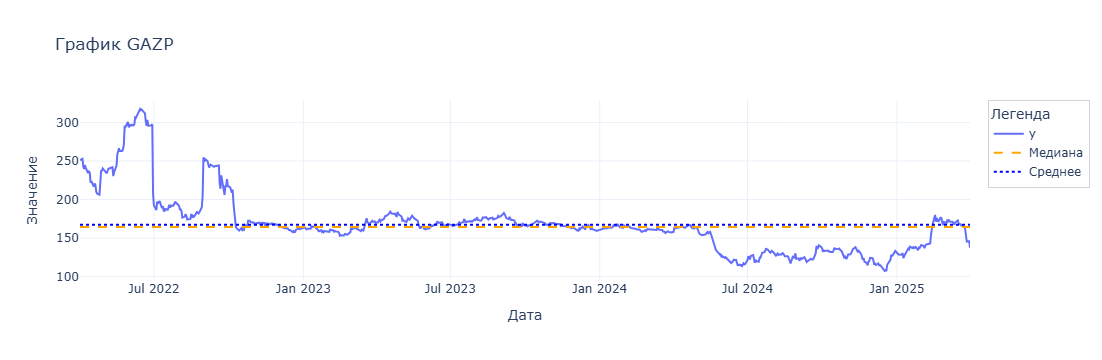

In [29]:
plotly_single_feature(df, column='y', title='График GAZP', save=False)

# Feature Engeneering для численных признаков

## Проверки на стационарность

In [32]:
# Настройки для ACF/PACF графиков
acf_pacf_style = {
    'lines.linewidth': 4,
    'lines.solid_capstyle': 'butt',
    'axes.labelsize': 'large',
    'axes.axisbelow': True,
    'axes.grid': True,
    'axes.linewidth': 3.0,
    'axes.titlesize': 'x-large',
    'grid.linestyle': '-',
    'grid.linewidth': 1.0,
    'xtick.major.size': 0,
    'xtick.minor.size': 0,
    'ytick.major.size': 0,
    'ytick.minor.size': 0,
    'figure.subplot.left': 0.08,
    'figure.subplot.right': 0.95,
    'figure.subplot.bottom': 0.07,
    'figure.figsize': (15, 12),  # переопределяется при вызове
    'figure.autolayout': True,
    'figure.dpi': 300,
    'font.size': 24.0
}

# Функция для построения ACF и PACF
def plot_acf_pacf(series, lags=40, figsize=(15, 12), title_prefix=""):
    """
    Рисует ACF и PACF графики с локальными параметрами оформления.
    """
    with plt.rc_context(acf_pacf_style):
        fig, ax = plt.subplots(2, 1, figsize=figsize)
        
        tsaplots.plot_acf(series.dropna(), ax=ax[0], lags=lags)
        ax[0].set_title(f"{title_prefix} ACF")
        ax[0].set_ylim(-1.05, 1.05)

        tsaplots.plot_pacf(series.dropna(), ax=ax[1], lags=lags)
        ax[1].set_title(f"{title_prefix} PACF")
        ax[1].set_ylim(-1.05, 1.05)

        plt.show()

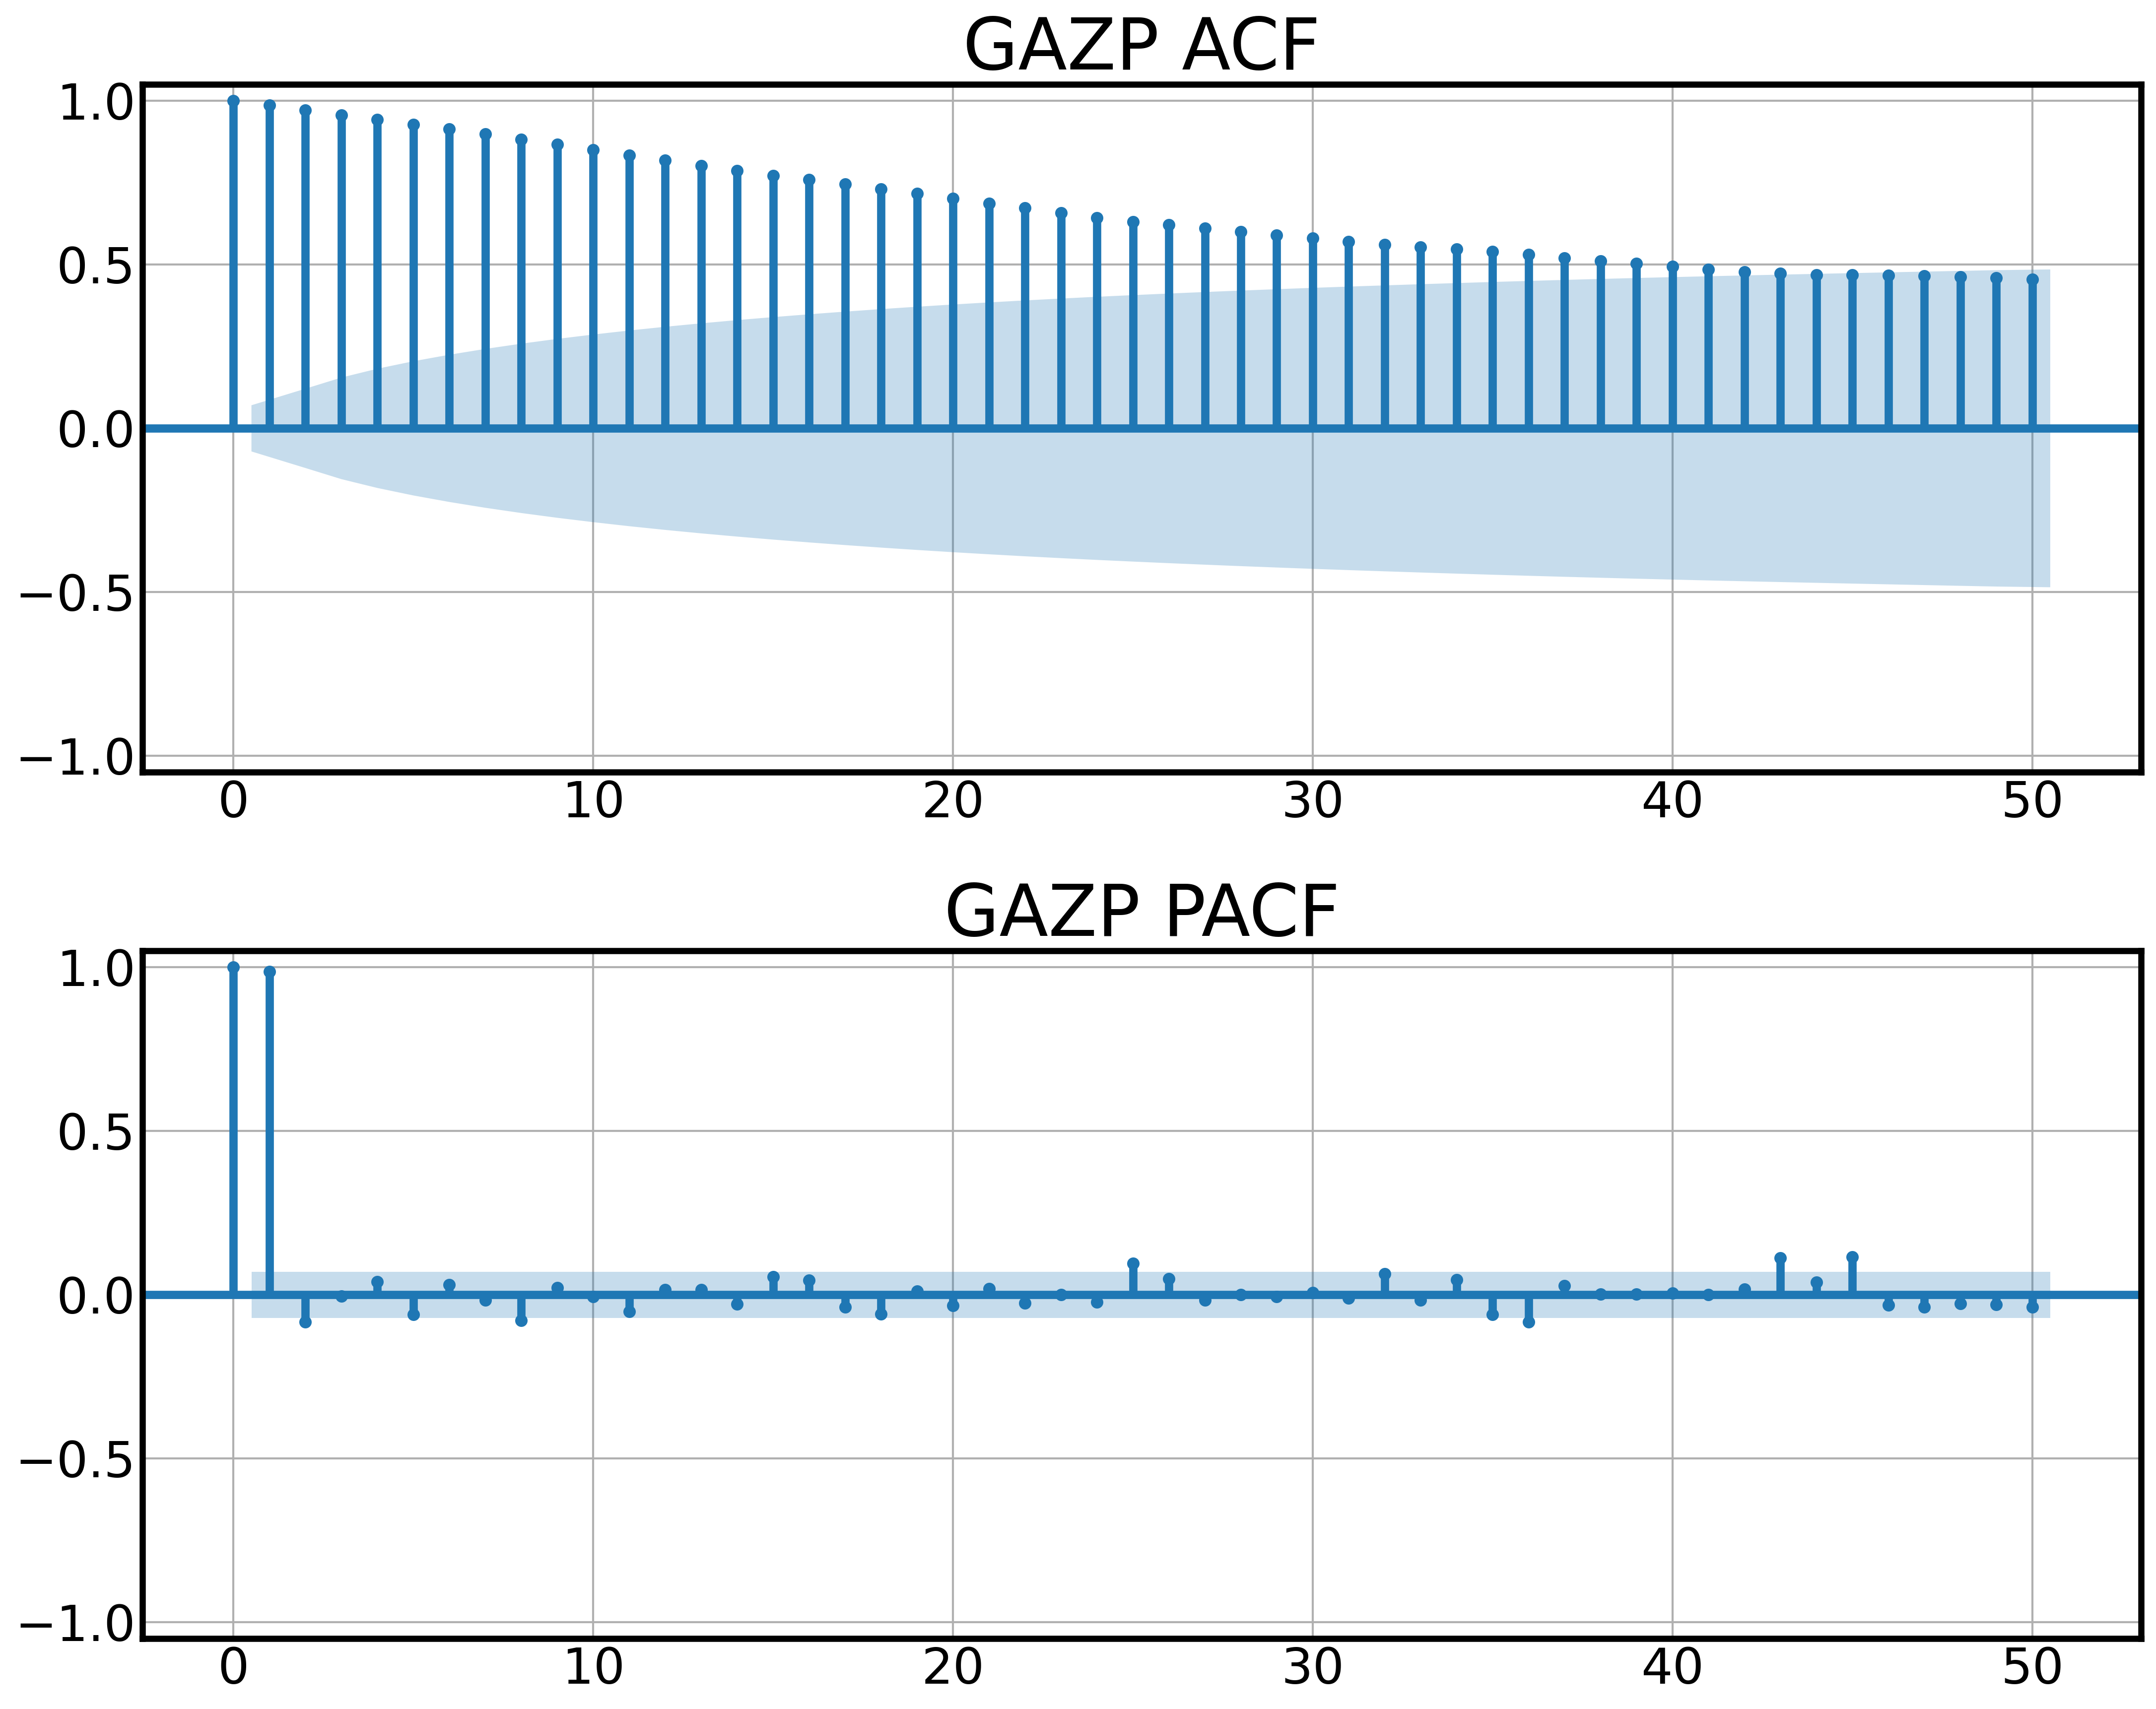

In [33]:
# Построить ACF/PACF
plot_acf_pacf(df['y'], lags=50, title_prefix="GAZP")

#### Ряд нестационарен

In [35]:
adf_test(df.y) # Дики-Фуллера, тестирует наличие единичного корня
print()
print('-------------------------------------------------------------------------')
print()
kpss_test(df.y, regression='c') # проверяет тренд - тренд-стационарность, то есть, наличие или отсутствие тренда

ADF Test (Augmented Dickey-Fuller)
H0: Временной ряд нестационарен (есть единичный корень)
H1: Временной ряд стационарен

Test Statistic                 -2.767
p-value                         0.063
# Lags Used                     7.000
Number of Observations Used   765.000
Critical Value (1%)            -3.439
Critical Value (5%)            -2.865
Critical Value (10%)           -2.569
dtype: float64

Интерпретация:
p-value = 0.0631 >= 0.05 => Не отклоняем H0: ряд считается нестационарным.

-------------------------------------------------------------------------

KPSS Test (regression='c')
H0: Временной ряд тренд-стационарен
H1: Временной ряд тренд-нестационарен

Test Statistic           2.545
p-value                  0.010
Lags Used               17.000
Critical Value (10%)     0.347
Critical Value (5%)      0.463
Critical Value (2.5%)    0.574
Critical Value (1%)      0.739
dtype: float64

Интерпретация:
p-value = 0.0100 < 0.05 => Отклоняем H0: ряд считается тренд-нестационарным.


C:\Users\smirn\AppData\Local\Temp\ipykernel_24244\385342457.py:34: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




#### Вывод: ряд нестационарен и тренд-нестационарен

#### Дифференцируем

In [38]:
# Вычисление первого дифференцирования
df['y_diff'] = df['y'].diff()

# Удаление строк с NaN после дифференцирования
df = df.dropna(subset=['y_diff'])

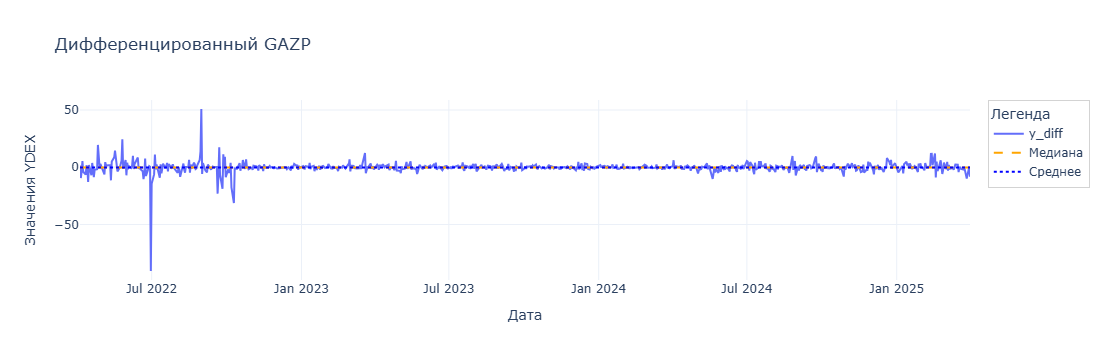

In [39]:
plotly_single_feature(df, column='y_diff', title='Дифференцированный GAZP', yaxis_title='Значения YDEX')

In [40]:
adf_test(df.y_diff) # Дики-Фуллера, тестирует наличие единичного корня
print()
print('-------------------------------------------------------------------------')
print()
kpss_test(df.y_diff, regression='c') # проверяет тренд - тренд-стационарность, то есть, наличие или отсутствие тренда

ADF Test (Augmented Dickey-Fuller)
H0: Временной ряд нестационарен (есть единичный корень)
H1: Временной ряд стационарен

Test Statistic                 -9.008
p-value                         0.000
# Lags Used                     6.000
Number of Observations Used   765.000
Critical Value (1%)            -3.439
Critical Value (5%)            -2.865
Critical Value (10%)           -2.569
dtype: float64

Интерпретация:
p-value = 0.0000 < 0.05 => Отклоняем H0: ряд считается стационарным.

-------------------------------------------------------------------------

KPSS Test (regression='c')
H0: Временной ряд тренд-стационарен
H1: Временной ряд тренд-нестационарен

Test Statistic          0.055
p-value                 0.100
Lags Used               5.000
Critical Value (10%)    0.347
Critical Value (5%)     0.463
Critical Value (2.5%)   0.574
Critical Value (1%)     0.739
dtype: float64

Интерпретация:
p-value = 0.1000 ≥ 0.05 => Не отклоняем H0: ряд считается тренд-стационарным.


C:\Users\smirn\AppData\Local\Temp\ipykernel_24244\385342457.py:34: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




#### Кажется, все получилось!
Есть совсем незначительные пробития без особо выраженной сезонности

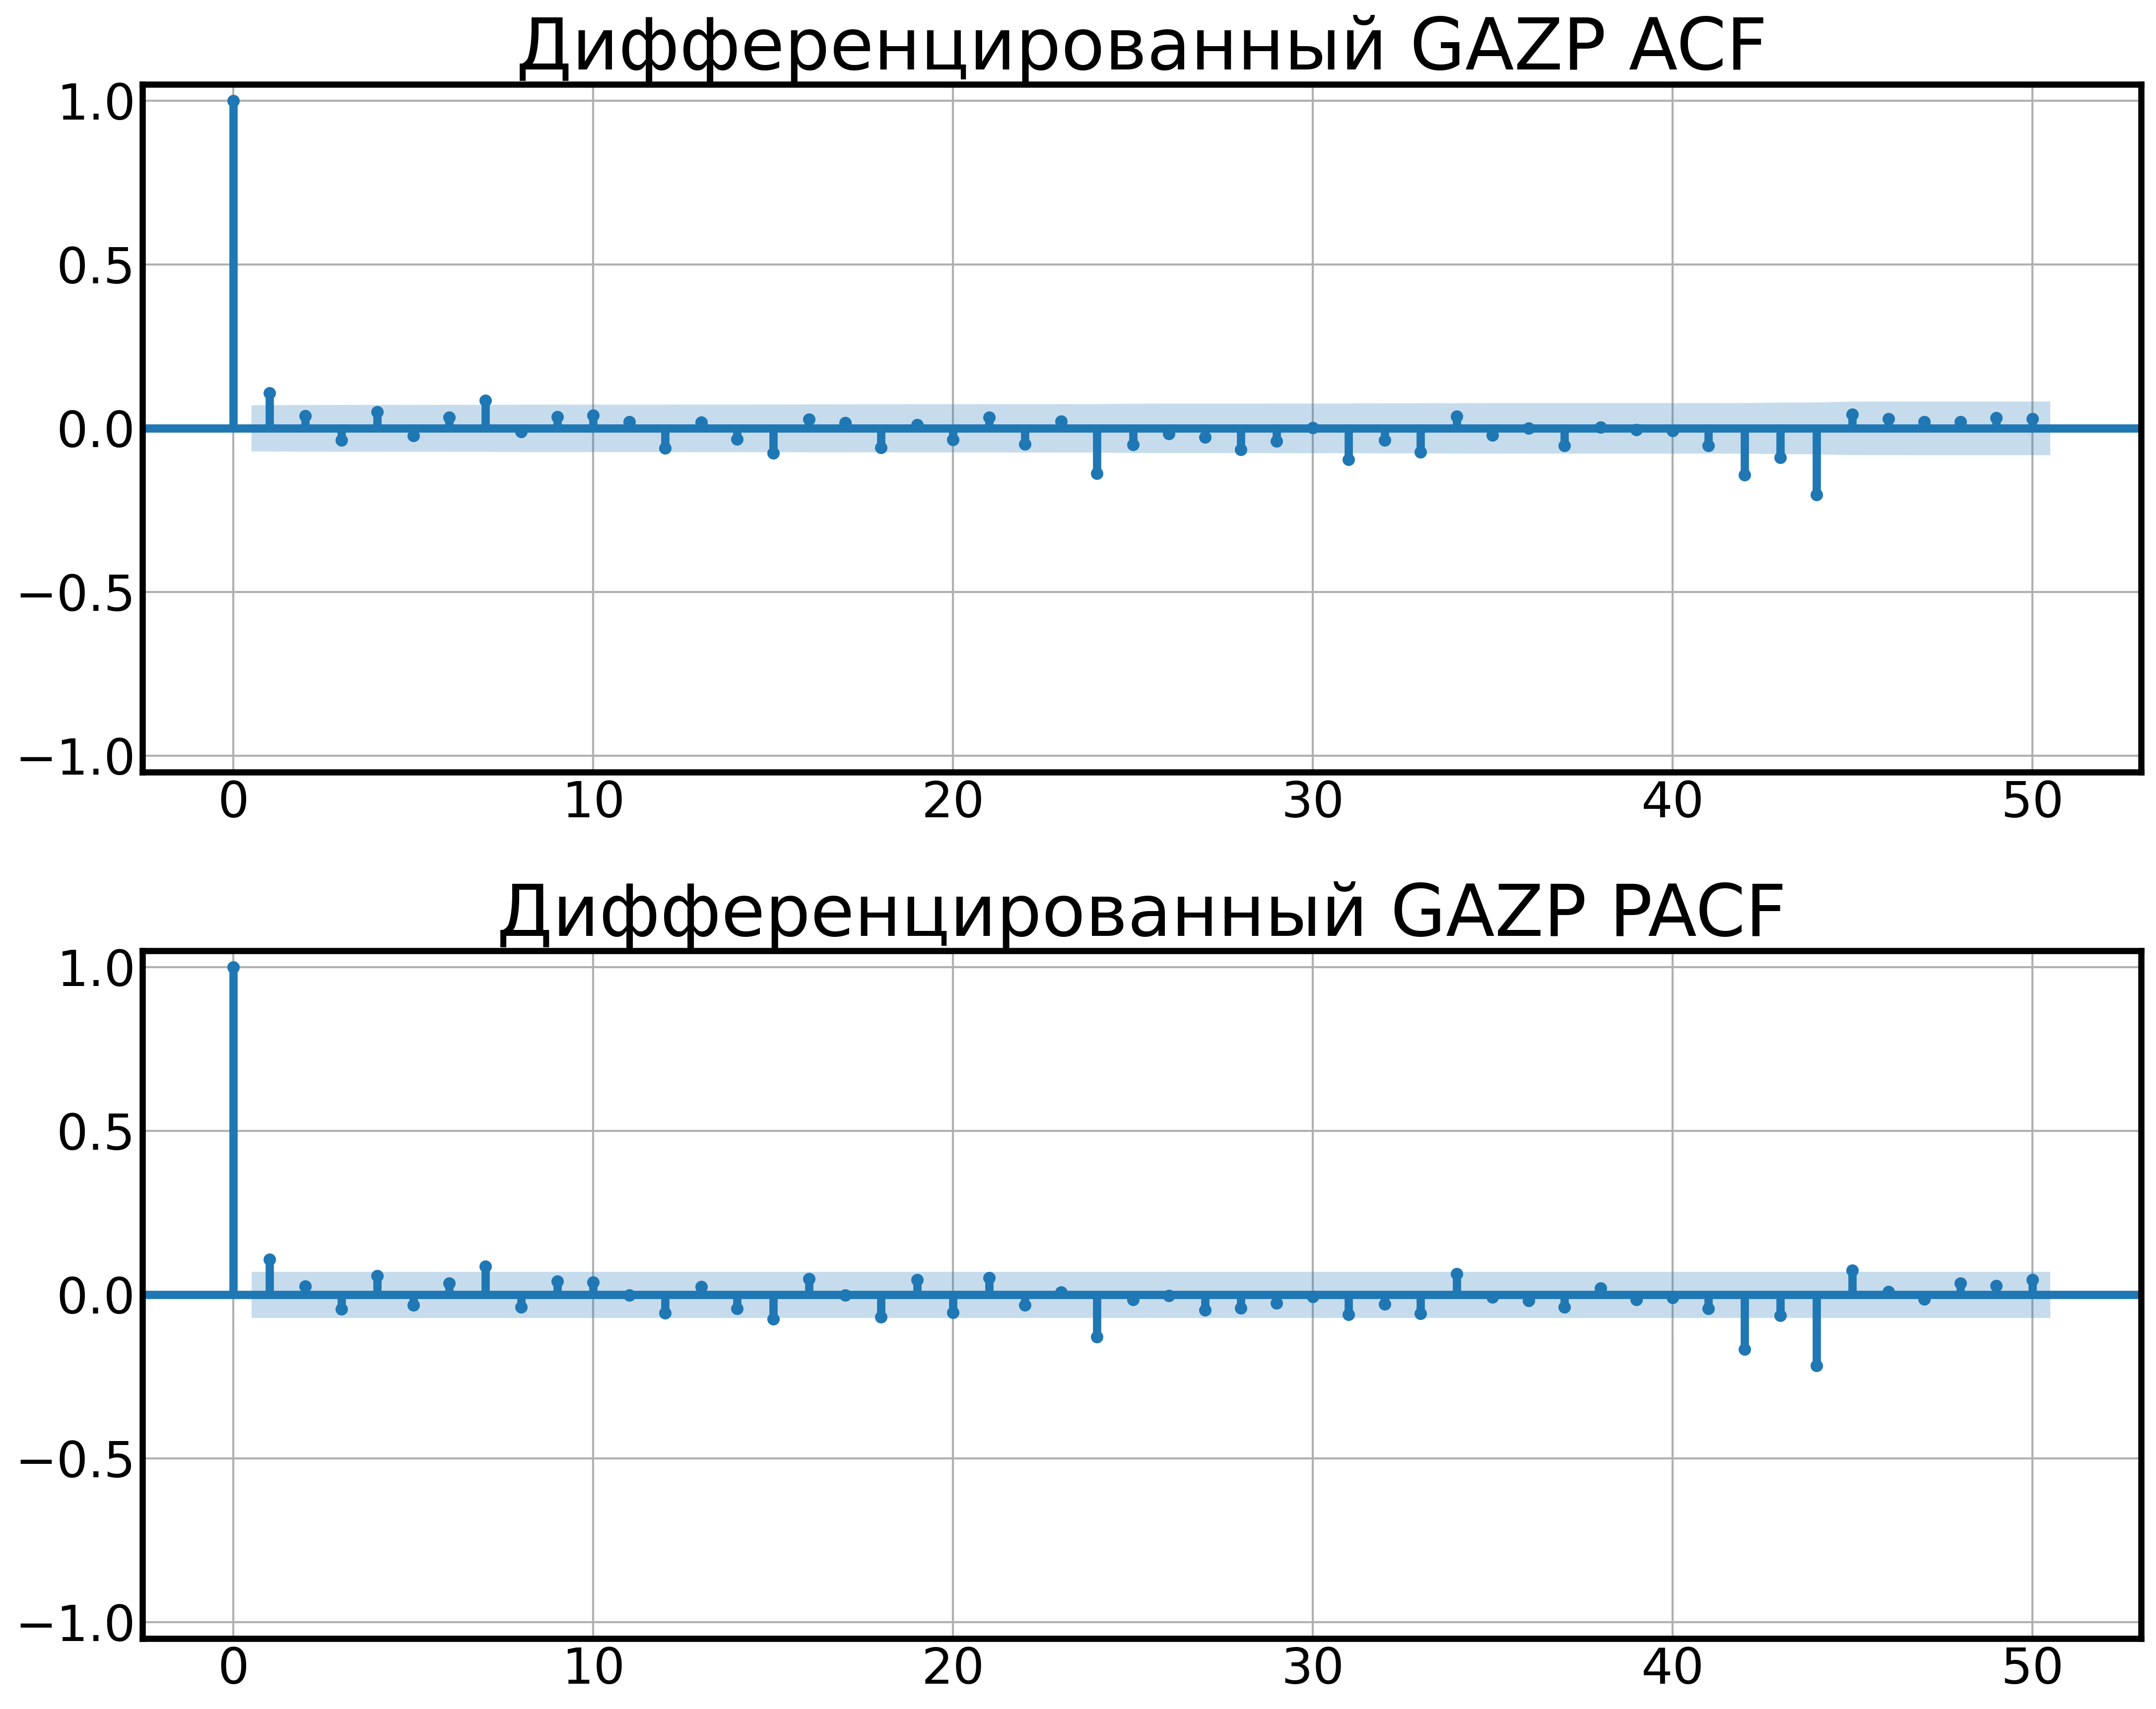

In [42]:
# Построить ACF/PACF
plot_acf_pacf(df['y_diff'], lags=50, title_prefix="Дифференцированный GAZP")

### Полиномы, логарифмы

In [44]:
df.columns

Index(['imoex_price', 'cb_rate', 'dxy_price', 'gold_price', 'west_price',
       'brent_price', 'eur_rub_price', 'usd_rub_price', 'moexog_close',
       'moexeu_close', 'moextl_close', 'moexmm_close', 'moexfn_close',
       'moexcn_close', 'moexch_close', 'moexit_close', 'moexre_close',
       'moextn_close', 'vix_price', 'djia_price', 'rvi_price', 'sp500_price',
       'nasdaq_price', 'ds', 'y', 'month', 'day', 'week', 'weekday',
       'dayofyear', 'season', 'quarter', 'holiday_name', 'is_holiday',
       'is_holiday_int', 'is_month_start', 'is_month_end', 'is_quarter_start',
       'is_quarter_end', 'month_sin', 'month_cos', 'weekday_sin',
       'weekday_cos', 'dayofyear_sin', 'dayofyear_cos', 'is_friday',
       'is_monday', 'weekday_group', 'week_of_month', 'days_since_start',
       'days_until_holiday', 'days_since_holiday', 'is_long_weekend',
       'is_day_before_long_weekend', 'is_day_after_long_weekend',
       'before_holiday_1d', 'after_holiday_1d', 'before_holiday_2d',
 

In [45]:
def add_nonlinear_variations(df, columns):
    """
    Добавляет логарифмы, квадраты и кубы для указанных признаков.

    Параметры:
    - df: DataFrame
    - columns: список названий столбцов, к которым применяются преобразования

    Преобразования:
    - log: log1p(abs(x)) - безопасно для отрицательных и нулей
    - squared: x^2
    - cubed: x^3

    Возвращает:
    - DataFrame с новыми признаками
    """
    df = df.copy()

    for col in columns:
        df[f'{col}_log'] = np.log1p(np.abs(df[col]))
        df[f'{col}_squared'] = df[col] ** 2
        df[f'{col}_cubed'] = df[col] ** 3

    return df

In [46]:
# Явно указываем нужные признаки
nonlinear_cols = [
    'dxy_price', 
    'gold_price', 
    'west_price', 
    'brent_price',
    'eur_rub_price', 
    'usd_rub_price', 
    'moexog_close', 
    'moexeu_close',
    'moextl_close', 
    'moexmm_close', 
    'moexfn_close', 
    'moexcn_close',
    'moexch_close', 
    'moexit_close', 
    'moexre_close', 
    'moextn_close',
    'vix_price', 
    'djia_price', 
    'rvi_price', 
    'sp500_price', 
    'nasdaq_price',
    'imoex_price'
]

# Применяем нелинейные преобразования
df = add_nonlinear_variations(df, nonlinear_cols)

In [47]:
def create_lag_features(
    df, 
    cols, 
    lags, 
    fill_value=None, 
    inplace=False, 
    drop_na=False, 
    prefix=None
):
    """
    Универсальная функция для добавления лагов к выбранным признакам DataFrame.

    Параметры:
    -----------
    df : pd.DataFrame
        Входной датафрейм.
    cols : str или list[str]
        Название столбца или список столбцов, для которых нужно создать лаги.
    lags : list[int]
        Список лагов (например, [7, 14, 21]).
    fill_value : значение или None
        Чем заполнять пропуски при смещении (например, 0, np.nan, None).
        Если None, не передаётся fill_value (по умолчанию NaN).
    inplace : bool
        Модифицировать исходный df или вернуть копию.
    drop_na : bool
        Если True, удалять строки с NaN после создания лагов.
    prefix : str или None
        Префикс для имён новых столбцов. Если None, имя как <col>_lag_<n>.
    """
    if not inplace:
        df = df.copy()
    if isinstance(cols, str):
        cols = [cols]
    for col in cols:
        for lag in lags:
            lag_col = f"{prefix or col}_lag_{lag}"
            if fill_value is not None:
                df[lag_col] = df[col].shift(lag, fill_value=fill_value)
            else:
                df[lag_col] = df[col].shift(lag)
    if drop_na:
        df.dropna(inplace=True)
    return df



numeric_columns = ['y']

feature_lags = [156, 169, 182, 195, 208, 221, 234, 247, 260, 273]

dff = create_lag_features(df, numeric_columns, feature_lags, fill_value=0, inplace=True)

### TRAIN / TEST SPLIT. Фактически, делаем OOT выборку, так как test отделен во времени от train

In [49]:
df = df.reset_index(drop=True)

In [50]:
y_original_train, y_original_test, X_train, y_train, X_test, y_test = split_train_test(
    df,
    train_ratio=0.8,
    target_col='y_diff',
    original_target_col='y',
    sort_by='ds'
)

In [51]:
y_original_train

0     252.900
1     243.500
2     239.700
3     245.000
4     241.070
        ...  
612   126.350
613   126.290
614   125.850
615   123.380
616   118.480
Name: y, Length: 617, dtype: float64

In [52]:
y_original_test

617   116.860
618   126.720
619   124.470
620   124.690
621   130.200
        ...  
767   161.850
768   155.250
769   145.430
770   145.690
771   137.500
Name: y, Length: 155, dtype: float64

In [53]:
df.isna().sum().any()

False

## Продолжим Feature Engineering

#### Target-Encoding

In [56]:
X_train

imoex_price  cb_rate  dxy_price  gold_price  west_price  brent_price  \
0       2787.690    0.200     99.000    5185.800     103.290      108.150   
1       2662.790    0.200     99.470    5185.420     101.980      106.600   
2       2611.430    0.200     99.600    5172.870      96.390      100.810   
3       2635.390    0.200     99.750    5162.480      96.050       99.830   
4       2592.720    0.200     99.800    4732.040      98.350      101.260   
..           ...      ...        ...         ...         ...          ...   
612     2826.130    0.180    102.460    7013.520      78.050       81.560   
613     2778.020    0.180    101.890    6993.500      75.820       81.090   
614     2772.710    0.180    101.440    7156.280      75.270       78.850   
615     2772.400    0.180    101.040    7273.830      72.760       78.770   
616     2726.810    0.180    101.510    7457.140      73.720       78.800   

     eur_rub_price  usd_rub_price  moexog_close  moexeu_close  moextl_close  \
0           91.920         81.495      7192.490      1477.140      1589.390   
1           91.611         81.750      6865.910      1426.090      1509.070   
2           89.500         80.000      6766.870      1427.670      1485.620   
3           86.106         76.750      6774.050      1436.500      1493.930   
4           87.296         77.750      6652.840      1427.910      1505.030   
..             ...            ...           ...           ...           ...   
612         98.641         89.445      7539.700      1747.470      1793.950   
613         99.566         89.820      7439.270      1731.050      1750.830   
614        101.445         91.145      7415.790      1728.200      1742.220   
615        102.008         91.496      7435.190      1734.150      1714.070   
616        101.453         91.300      7302.740      1690.310      1663.490   

     moexmm_close  moexfn_close  moexcn_close  moexch_close  moexit_close  \
0        9278.810      7487.570      6622.470     34738.470      2223.420   
1        9095.940      7062.270      6241.010     33156.480      2095.040   
2        9023.810      6788.570      6177.800     35470.780      2015.430   
3        9024.140      6902.900      6143.590     34764.850      2051.020   
4        8870.510      6720.840      6161.120     33552.690      2052.560   
..            ...           ...           ...           ...           ...   
612      6945.160      9886.590      7765.380     30099.970      3297.610   
613      6809.540      9704.700      7632.690     29517.760      3203.660   
614      6775.240      9737.020      7643.310     29418.720      3185.770   
615      6699.530      9713.780      7647.340     29051.490      3133.830   
616      6507.620      9589.420      7596.700     28779.500      3080.810   

     moexre_close  moextn_close  vix_price  djia_price  rvi_price  \
0        7441.640      1033.290     18.570      17.380     95.910   
1        6845.510       984.290     21.030      19.620     95.520   
2        6634.590       991.440     22.100      20.100     98.000   
3        6954.560      1007.510     21.550      20.040     91.000   
4        6802.670       986.900     21.160      19.530     94.340   
..            ...           ...        ...         ...        ...   
612      8536.480      1653.090     14.800      13.350     28.010   
613      8316.440      1631.390     14.650      12.880     31.230   
614      8250.220      1634.520     15.880      13.520     31.360   
615      8340.030      1616.500     16.270      14.000     32.700   
616      8047.470      1571.000     17.550      15.370     34.170   

     sp500_price  nasdaq_price         ds  month  day  week  weekday  \
0       4582.640     14532.550 2022-04-04      4    4    14        0   
1       4525.120     14204.170 2022-04-05      4    5    14        1   
2       4481.150     13888.820 2022-04-06      4    6    14        2   
3       4500.210     13897.300 2022-04-07      4    7    14        3   
4       4488.280 

In [57]:
(X_train.dtypes == 'object').sum()

3

In [58]:
# Категориальные признаки
cat_features = [
    'holiday_name',
    'season',
    'weekday_group'
]

# Кодировщик
cb_enc = ce.CatBoostEncoder(cols=cat_features)
cb_enc = cb_enc.fit(X_train[cat_features], y_train)

# Кодируем и присоединяем закодированные фичи
X_train = X_train.join(cb_enc.transform(X_train[cat_features]).add_suffix('_cb'))
X_test = X_test.join(cb_enc.transform(X_test[cat_features]).add_suffix('_cb'))

# Удаляем оригинальные категориальные признаки
X_train = X_train.drop(columns=cat_features)
X_test = X_test.drop(columns=cat_features)

### Feature Selection

In [60]:
X_train

imoex_price  cb_rate  dxy_price  gold_price  west_price  brent_price  \
0       2787.690    0.200     99.000    5185.800     103.290      108.150   
1       2662.790    0.200     99.470    5185.420     101.980      106.600   
2       2611.430    0.200     99.600    5172.870      96.390      100.810   
3       2635.390    0.200     99.750    5162.480      96.050       99.830   
4       2592.720    0.200     99.800    4732.040      98.350      101.260   
..           ...      ...        ...         ...         ...          ...   
612     2826.130    0.180    102.460    7013.520      78.050       81.560   
613     2778.020    0.180    101.890    6993.500      75.820       81.090   
614     2772.710    0.180    101.440    7156.280      75.270       78.850   
615     2772.400    0.180    101.040    7273.830      72.760       78.770   
616     2726.810    0.180    101.510    7457.140      73.720       78.800   

     eur_rub_price  usd_rub_price  moexog_close  moexeu_close  moextl_close  \
0           91.920         81.495      7192.490      1477.140      1589.390   
1           91.611         81.750      6865.910      1426.090      1509.070   
2           89.500         80.000      6766.870      1427.670      1485.620   
3           86.106         76.750      6774.050      1436.500      1493.930   
4           87.296         77.750      6652.840      1427.910      1505.030   
..             ...            ...           ...           ...           ...   
612         98.641         89.445      7539.700      1747.470      1793.950   
613         99.566         89.820      7439.270      1731.050      1750.830   
614        101.445         91.145      7415.790      1728.200      1742.220   
615        102.008         91.496      7435.190      1734.150      1714.070   
616        101.453         91.300      7302.740      1690.310      1663.490   

     moexmm_close  moexfn_close  moexcn_close  moexch_close  moexit_close  \
0        9278.810      7487.570      6622.470     34738.470      2223.420   
1        9095.940      7062.270      6241.010     33156.480      2095.040   
2        9023.810      6788.570      6177.800     35470.780      2015.430   
3        9024.140      6902.900      6143.590     34764.850      2051.020   
4        8870.510      6720.840      6161.120     33552.690      2052.560   
..            ...           ...           ...           ...           ...   
612      6945.160      9886.590      7765.380     30099.970      3297.610   
613      6809.540      9704.700      7632.690     29517.760      3203.660   
614      6775.240      9737.020      7643.310     29418.720      3185.770   
615      6699.530      9713.780      7647.340     29051.490      3133.830   
616      6507.620      9589.420      7596.700     28779.500      3080.810   

     moexre_close  moextn_close  vix_price  djia_price  rvi_price  \
0        7441.640      1033.290     18.570      17.380     95.910   
1        6845.510       984.290     21.030      19.620     95.520   
2        6634.590       991.440     22.100      20.100     98.000   
3        6954.560      1007.510     21.550      20.040     91.000   
4        6802.670       986.900     21.160      19.530     94.340   
..            ...           ...        ...         ...        ...   
612      8536.480      1653.090     14.800      13.350     28.010   
613      8316.440      1631.390     14.650      12.880     31.230   
614      8250.220      1634.520     15.880      13.520     31.360   
615      8340.030      1616.500     16.270      14.000     32.700   
616      8047.470      1571.000     17.550      15.370     34.170   

     sp500_price  nasdaq_price         ds  month  day  week  weekday  \
0       4582.640     14532.550 2022-04-04      4    4    14        0   
1       4525.120     14204.170 2022-04-05      4    5    14        1   
2       4481.150     13888.820 2022-04-06      4    6    14        2   
3       4500.210     13897.300 2022-04-07      4    7    14        3   
4       4488.280 

In [61]:
columns = list(X_train.columns.difference(['ds']))
model_features = columns

SHAP summary plot for GAZP


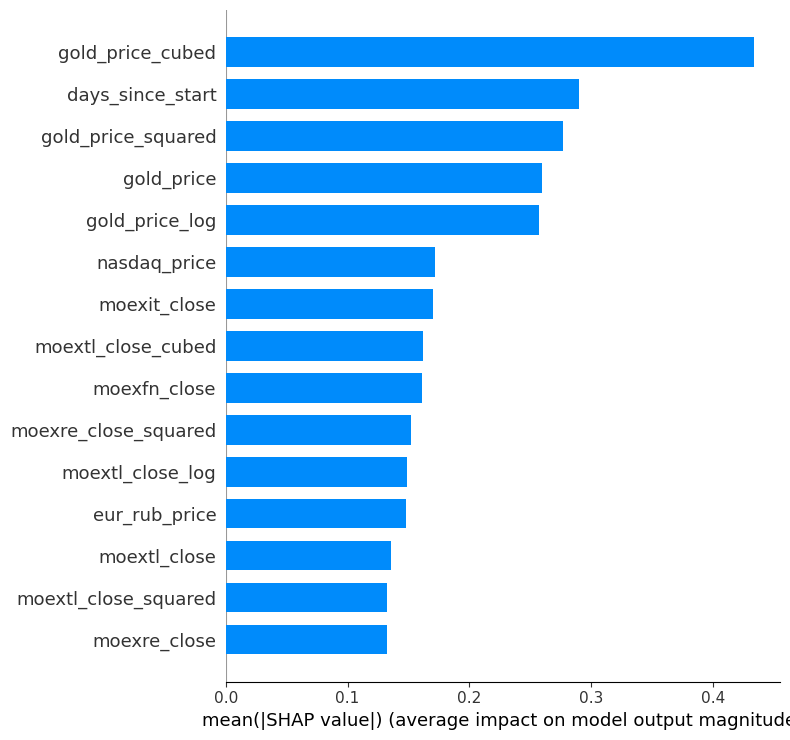

In [62]:
def calculate_shap_feature_importance(
    X_train: pd.DataFrame,
    y_train: Union[pd.Series, np.ndarray],
    X_shap: Optional[pd.DataFrame] = None,
    y_shap: Optional[Union[pd.Series, np.ndarray]] = None,
    model_params: Optional[dict] = None,
    max_display: int = 30,
    plot: bool = True,
    sample_size: int = 1000,
    target_name: Optional[str] = None,
    plot_type: str = "bar",
    cat_features: Optional[list] = None,
    sampling_strategy: str = "last",  # or "random"
    shap_mode: str = "interventional"  # or "tree_path_dependent"
) -> tuple[pd.DataFrame, np.ndarray]:
    """
    Fits a CatBoostRegressor on X_train/y_train and computes SHAP values on X_shap.
    Supports interventional mode for more accurate SHAP values on correlated time series data.
    """

    assert shap_mode in ["tree_path_dependent", "interventional"], \
        "shap_mode must be 'tree_path_dependent' or 'interventional'"

    assert isinstance(X_train, pd.DataFrame), "X_train must be a pandas DataFrame"
    assert isinstance(y_train, (pd.Series, np.ndarray)), "y_train must be Series or ndarray"
    assert X_train.shape[0] == len(y_train), "X_train and y_train must have the same number of samples"

    if model_params is None:
        model_params = {
            'iterations': 1000,
            'learning_rate': 0.1,
            'depth': 5, 
            'random_seed': 42,
            'verbose': False,
            'task_type': 'CPU'
        }

    if X_shap is None:
        X_shap = X_train.copy()
        y_shap = y_train

    if X_shap.shape[0] > sample_size:
        warnings.warn(
            f"X_shap contains {X_shap.shape[0]} rows. Sampling {sample_size} rows for SHAP.",
            UserWarning
        )
        if sampling_strategy == "last":
            X_sample = X_shap.iloc[-sample_size:].copy()
            y_sample = y_shap[-sample_size:] if isinstance(y_shap, (pd.Series, np.ndarray)) else y_shap.iloc[-sample_size:]
        elif sampling_strategy == "random":
            X_sample = X_shap.sample(n=sample_size, random_state=42)
            y_sample = y_shap[X_sample.index]
        else:
            raise ValueError(f"Unknown sampling_strategy: {sampling_strategy}")
    else:
        X_sample = X_shap.copy()
        y_sample = y_shap

    model = CatBoostRegressor(**model_params)
    model.fit(X_train, y_train, cat_features=cat_features)

    if shap_mode == "interventional":
        explainer = shap.TreeExplainer(model, data=X_train, feature_perturbation="interventional")
    else:
        explainer = shap.TreeExplainer(model, feature_perturbation="tree_path_dependent")

    shap_values = explainer.shap_values(X_sample)

    if isinstance(shap_values, list):
        if len(shap_values) > 1:
            warnings.warn("Multiple outputs detected. Using the first output.", UserWarning)
        shap_values = shap_values[0]

    assert shap_values.shape[1] == X_sample.shape[1], \
        "Mismatch between SHAP values and feature dimensions."

    if plot:
        title = f"SHAP summary plot{' for ' + target_name if target_name else ''}"
        print(title)
        shap.summary_plot(
            shap_values,
            X_sample,
            max_display=max_display,
            plot_type=plot_type if plot_type == "beeswarm" else "bar",
            show=False
        )
        plt.show()

    mean_abs_shap = np.abs(shap_values).mean(axis=0)
    shap_df = pd.DataFrame({
        'feature': X_sample.columns,
        'mean_abs_shap': mean_abs_shap
    }).sort_values(by='mean_abs_shap', ascending=False).reset_index(drop=True)

    return shap_df, shap_values

shap_df, shap_values = calculate_shap_feature_importance(
    X_train=X_train[model_features],
    y_train=y_train,
    X_shap=X_test[model_features],
    y_shap=y_test,
    max_display=15,
    target_name='GAZP',
    sampling_strategy='last',
    shap_mode='interventional'
)

#### Заменю на корреляцию Пирсона

In [64]:
def filter_features_by_shap_and_correlation(
    shap_df: pd.DataFrame,
    X: pd.DataFrame,
    shap_values: np.ndarray,
    threshold: float = 0.9,
    corr_threshold: float = 0.9
) -> list:
    """
    Отбирает признаки по SHAP важности и устраняет коррелированные (через кластеризацию).

    Преобразования:
    - SHAP отбор по кумулятивной важности
    - корреляционная матрица очищается от NaN (заполняется 0)
    - кластеризация по 1 - |corr|

    Возвращает:
    - List[str]: финальный список отобранных признаков
    """

    # Step 1: Top SHAP features
    shap_df_sorted = shap_df.sort_values(by='mean_abs_shap', ascending=False).reset_index(drop=True)
    total = shap_df_sorted['mean_abs_shap'].sum()
    shap_df_sorted['cumulative'] = shap_df_sorted['mean_abs_shap'].cumsum() / total

    selected = shap_df_sorted[shap_df_sorted['cumulative'] <= threshold]
    if not selected.empty and selected.shape[0] < shap_df_sorted.shape[0]:
        selected = shap_df_sorted.iloc[:selected.shape[0] + 1]

    selected_features = selected['feature'].tolist()
    X_selected = X[selected_features]

    # Step 2: Correlation clustering with safe handling
    corr_matrix = X_selected.corr().abs().fillna(0)          
    distance_matrix = 1 - corr_matrix
    distance_matrix = (distance_matrix + distance_matrix.T) / 2
    np.fill_diagonal(distance_matrix.values, 0)

    # Step 3: Convert to condensed distance matrix
    condensed = squareform(distance_matrix.values, checks=False)
    linkage_matrix = linkage(condensed, method='average')
    clusters = fcluster(linkage_matrix, t=1 - corr_threshold, criterion='distance')

    # Step 4: Retain top SHAP feature per cluster
    cluster_df = pd.DataFrame({'feature': selected_features, 'cluster': clusters})
    retained = []
    for cluster_id in cluster_df['cluster'].unique():
        cluster_features = cluster_df[cluster_df['cluster'] == cluster_id]['feature']
        top = shap_df_sorted[shap_df_sorted['feature'].isin(cluster_features)].iloc[0]['feature']
        retained.append(top)

    return retained

In [65]:
len(X_test)

155

In [66]:
selected_features = filter_features_by_shap_and_correlation(
    shap_df=shap_df,
    X=X_test[model_features],
    shap_values=shap_values,
    threshold=0.7,
    corr_threshold=0.99
)
print(selected_features)
model_features_arima = selected_features

# ['days_since_start', 'gold_price', 'brent_price', 'day', 'moexre_close', 
#  'moextl_close_squared', 'dxy_price_log', 'moexmm_close', 'west_price', 
#  'djia_price', 'eur_rub_price', 'sp500_price', 'weekday_sin', 'usd_rub_price', 
#  'djia_price_cubed', 'moexch_close_cubed']

['gold_price_cubed', 'days_since_start', 'nasdaq_price', 'moexit_close', 'moextl_close_cubed', 'moexfn_close', 'moexre_close_squared', 'eur_rub_price', 'y_lag_234', 'day', 'dxy_price', 'moextn_close', 'moexch_close_cubed', 'brent_price_log', 'month_cos', 'dayofyear', 'west_price', 'y_lag_156', 'month_sin', 'sp500_price_squared', 'djia_price_squared', 'imoex_price_log', 'weekday_sin', 'moexeu_close_log', 'usd_rub_price', 'rvi_price_log', 'dayofyear_sin']


In [67]:
# model_features_arima = ['days_since_start', 
#                         'y_lag_234',
#                         'y_lag_156',
#                         'y_lag_169',
#                         'y_lag_182',
#                         'y_lag_195',
#                         'y_lag_208',
#                         'y_lag_221',
#                         'y_lag_234',
#                         'y_lag_247',
#                         'y_lag_260',
#                         'y_lag_273',
#                         'gold_price', 
#                         'brent_price', 'day', 'moexre_close', 
#                         'moextl_close_squared', 'dxy_price_log', 'moexmm_close', 'west_price', 
#                         'djia_price', 'eur_rub_price', 'sp500_price', 'weekday_sin', 'usd_rub_price', 
#                         'djia_price_cubed', 
#                         'moexch_close_cubed'
       
#                        ]
model_features_arima = selected_features

In [68]:
# date_threshold = pd.to_datetime('2022-10-10')

# mask = X_train['ds'] >= date_threshold

# X_train_filtered = X_train.loc[mask].reset_index(drop=True)
# y_train_filtered = y_train.loc[mask].reset_index(drop=True)

# y_original_train_filtered = y_original_train.loc[mask].reset_index(drop=True)
# y_original_test_filtered = y_original_test.loc[mask].reset_index(drop=True)

#### Данный набор признаков показал себя лучше всего

# ARIMA

In [71]:
# def calc_optimum_sarima_rmse(y_train, X_train, y_test, X_test,
#                                          max_p, max_P, max_q, max_Q,
#                                          d, D,
#                                          min_s=1, max_s=12):

#     if isinstance(y_train, np.ndarray):
#         y_train = pd.Series(y_train)
#     if isinstance(y_test, np.ndarray):
#         y_test = pd.Series(y_test)

#     ps = range(0, max_p + 1)
#     qs = range(0, max_q + 1)
#     Ps = range(0, max_P + 1)
#     Qs = range(0, max_Q + 1)
#     Ss = [s for s in range(min_s, max_s + 1) if s >= 1]

#     parameters = list(product(ps, qs, Ps, Qs, Ss))

#     best_rmse = float('inf')
#     best_model = None
#     best_param = None
#     results = []

#     print(f"Total combinations to check: {len(parameters)}")

#     for param in tqdm(parameters, desc="Grid search SARIMA"):
#         try:
#             p, q, P, Q, s = param
#             with warnings.catch_warnings():
#                 warnings.simplefilter("ignore")
#                 model = SARIMAX(
#                     y_train,
#                     exog=X_train,
#                     order=(p, d, q),
#                     seasonal_order=(P, D, Q, s),
#                     enforce_stationarity=False,
#                     enforce_invertibility=False
#                 ).fit(disp=False)

#             forecast = model.forecast(steps=len(y_test), exog=X_test)
#             rmse = np.sqrt(mean_squared_error(y_test, forecast))

#             results.append({'params': param, 'rmse': rmse})

#             if rmse < best_rmse:
#                 best_rmse = rmse
#                 best_model = model
#                 best_param = param

#         except Exception as e:
#             print(f"Failed for parameters {param}: {e}")
#             continue

#     print("\nBest model specification:")
#     print(f"order=({best_param[0]}, {d}, {best_param[1]}), seasonal_order=({best_param[2]}, {D}, {best_param[3]}, {best_param[4]})")
#     print(f"Best RMSE: {best_rmse:.4f}")

#     return results, best_model, best_param

# results, final_arima_model, best_param = calc_optimum_sarima_rmse(
#     y_train=np.log(y_original_train),
#     X_train=X_train[model_features_arima],
#     y_test=np.log(y_original_test),
#     X_test=X_test[model_features_arima],
#     max_p=1, 
#     max_P=4, 
#     max_q=1, 
#     max_Q=0,
#     d=1,
#     D=1,
#     min_s=2, 
#     max_s=6
# )

In [72]:
# cov_type='robust'

In [73]:
final_arima_model = SARIMAX(
    endog=np.log(y_original_train),
    exog=X_train[model_features_arima],
    order=(1, 1, 1),
    seasonal_order=(4, 1, 0, 6),
    enforce_stationarity=False,
    enforce_invertibility=False,
    missing='drop'
    # trend='c'
).fit(cov_type='robust')

final_arima_model.summary()

D:\Anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  617
Model:             SARIMAX(1, 1, 1)x(4, 1, [], 6)   Log Likelihood                1428.046
Date:                            Sun, 25 May 2025   AIC                          -2788.092
Time:                                    16:54:38   BIC                          -2639.458
Sample:                                         0   HQIC                         -2730.166
                                            - 617                                         
Covariance Type:                           robust                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
gold_price_cubed      3.757e-14   8.03e-14      0.468      0.640    -1.2e-13    1.95e-13
days_since_start        -0.0022        nan        nan        nan         nan         nan
nasdaq_price          2.314e-06   7.49e-13   3.09e+06      0.000    2.31e-06    2.31e-06
moexit_close         -4.901e-05   1.06e-14  -4.61e+09      0.000    -4.9e-05    -4.9e-05
moextl_close_cubed      3.7e-13   3.53e-12      0.105      0.917   -6.55e-12    7.29e-12
moexfn_close         -7.678e-05        nan        nan        nan         nan         nan
moexre_close_squared -3.737e-10   3.71e-10     -1.007      0.314    -1.1e-09    3.53e-10
eur_rub_price          6.66e-05   2.22e-15      3e+10      0.000    6.66e-05    6.66e-05
y_lag_234              5.13e-05   6.49e-15   7.91e+09      0.000    5.13e-05    5.13e-05
day                      0.0001   2.31e-15   5.21e+10      0.000       0.000       0.000
dxy_price                0.0042   8.81e-16   4.77e+12      0.000       0.004       0.004
moextn_close          3.095e-05   1.26e-14   2.46e+09      0.000    3.09e-05    3.09e-05
moexch_close_cubed   -2.293e-16   3.63e-16     -0.631      0.528   -9.41e-16    4.83e-16
brent_price_log         -0.1508   2.19e-17  -6.88e+15      0.000      -0.151      -0.151
month_cos               -0.0201        nan        nan        nan         nan         nan
dayofyear             6.528e-06   1.95e-14   3.35e+08      0.000    6.53e-06    6.53e-06
west_price               0.0009   2.31e-15   3.98e+11      0.000       0.001       0.001
y_lag_156             4.483e-05        nan        nan        nan         nan         nan
month_sin                0.0050   1.67e-17      3e+14      0.000       0.005       0.005
sp500_price_squared   2.582e-09   1.78e-09      1.449      0.147    -9.1e-10    6.07e-09
djia_price_squared    1.312e-05   1.59e-13   8.24e+07      0.000    1.31e-05    1.31e-05
imoex_price_log          2.1080   1.75e-17   1.21e+17      0.000       2.108       2.108
weekday_sin              0.0021   1.58e-16    1.3e+13      0.000       0.002       0.002
moexeu_close_log        -0.0966   1.28e-17  -7.57e+15      0.000      -0.097      -0.097
usd_rub_price           -0.0043    3.5e-16  -1.24e+13      0.000      -0.004      -0.004
rvi_price_log           -0.0074        nan        nan        nan         nan         nan
dayofyear_sin           -0.0399   1.55e-18  -2.57e+16      0.000      -0.040      -0.040
ar.L1                    0.3398        nan        nan        nan         nan         nan
ma.L1                   -0.2572        nan        nan        nan         nan         nan
ar.S.L6                 -0.6531        nan        nan        nan         nan         nan
ar.S.L12                -0.5666   1.51e-17  -3.75e+16      0.000      -0.567      -0.567
ar.S.L18                -0.3288    8.2e-18  -4.01e+16      0.000      -0.329      -0.329
ar.S.L24          


Ljung–Box test (lag=50) p-value: 0.0068


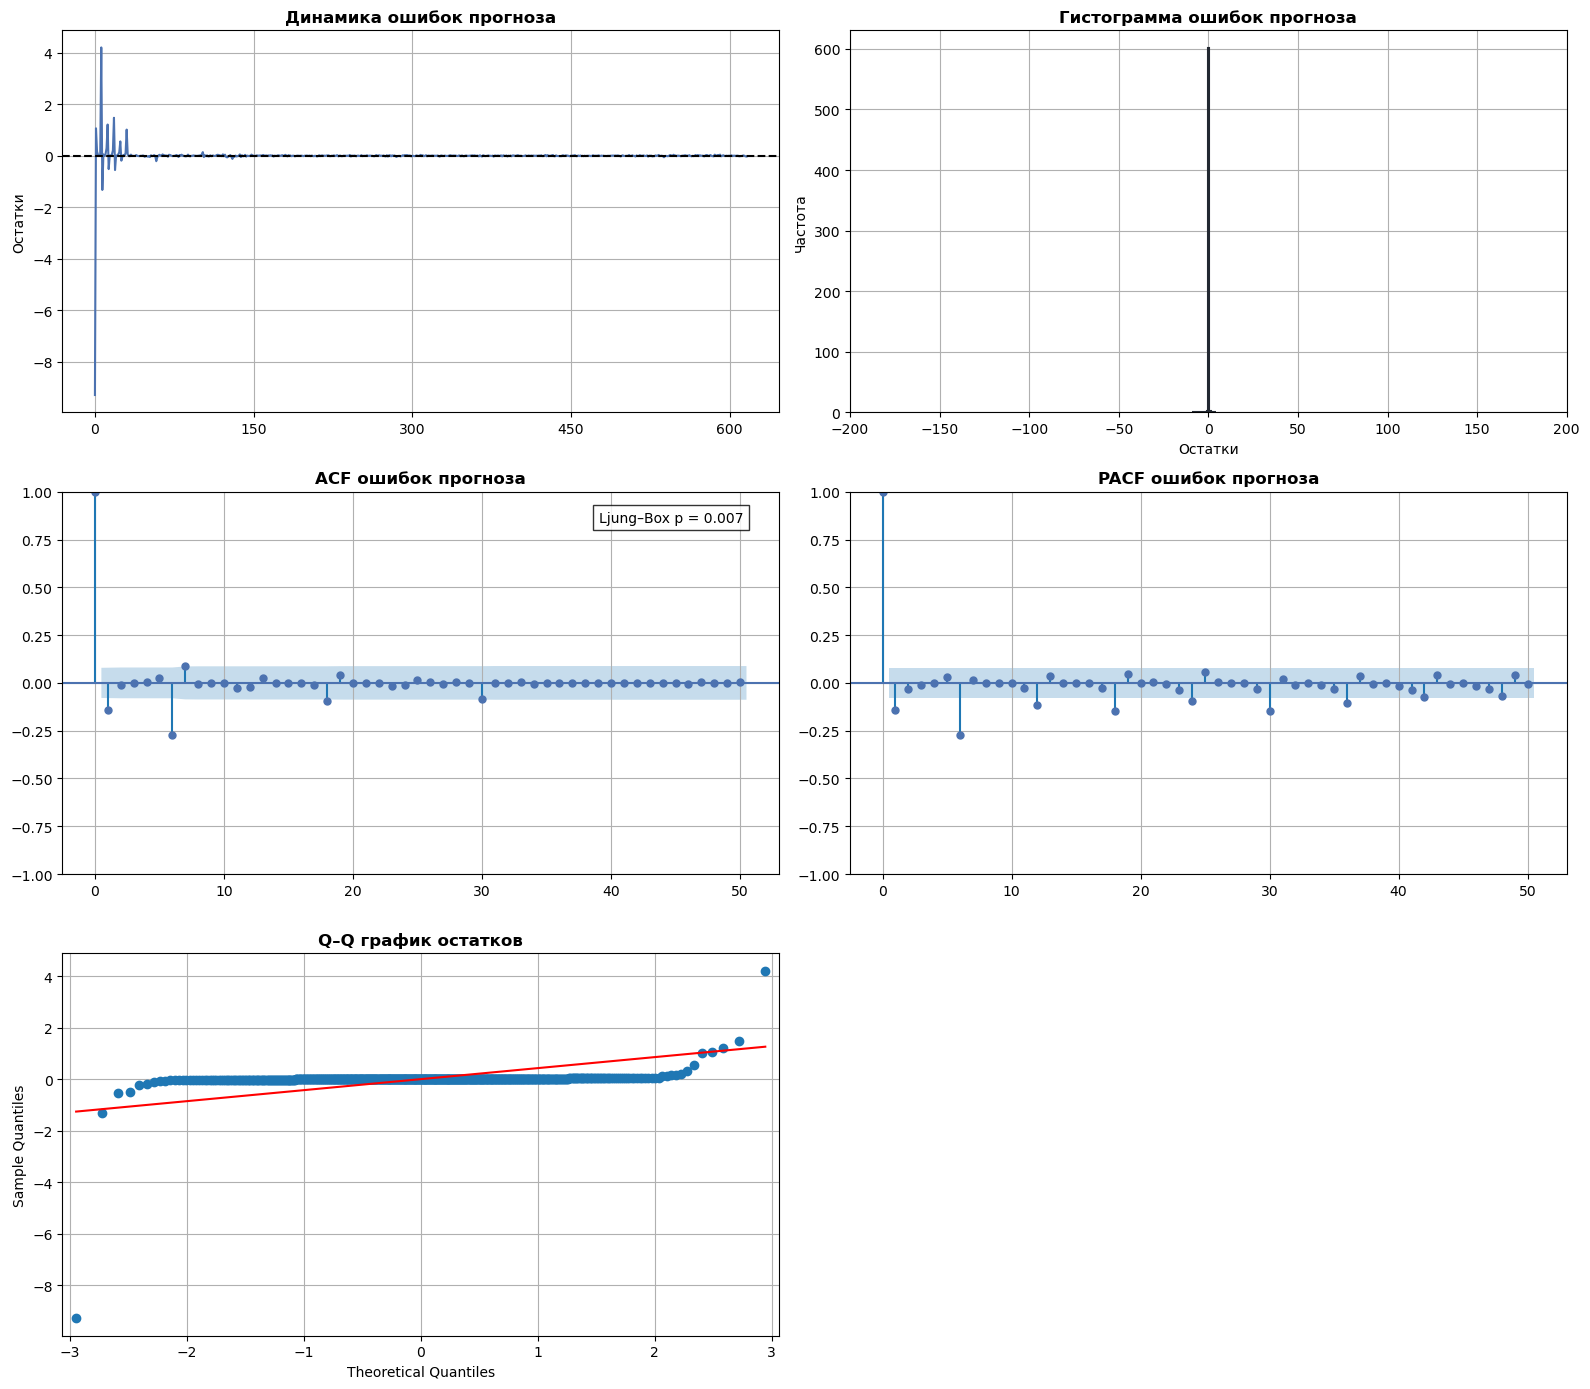

In [74]:
final_arima_model_residuals = pd.Series(final_arima_model.resid, name='resid')

df_diagnostics = pd.DataFrame({
    'date': y_train.index,
    'resid': final_arima_model_residuals.values
})

plot_diagnostics(df_diagnostics, dt_col='date', resid_col='resid', lags=50)

In [75]:
results = check_fit(final_arima_model_residuals.values)
pd.DataFrame([results]).T

0
mean_resids              -0.002
mean_t                   -0.117
mean_pval                 0.907
stationary_t            -16.468
stationary_pval           0.000
norm_stat                 0.087
norm_pval                 0.000
autocor_pass              False
heteroscedasticity_f      4.863
heteroscedasticity_pval   0.028
check_result              False

#### Визуализируем предсказание

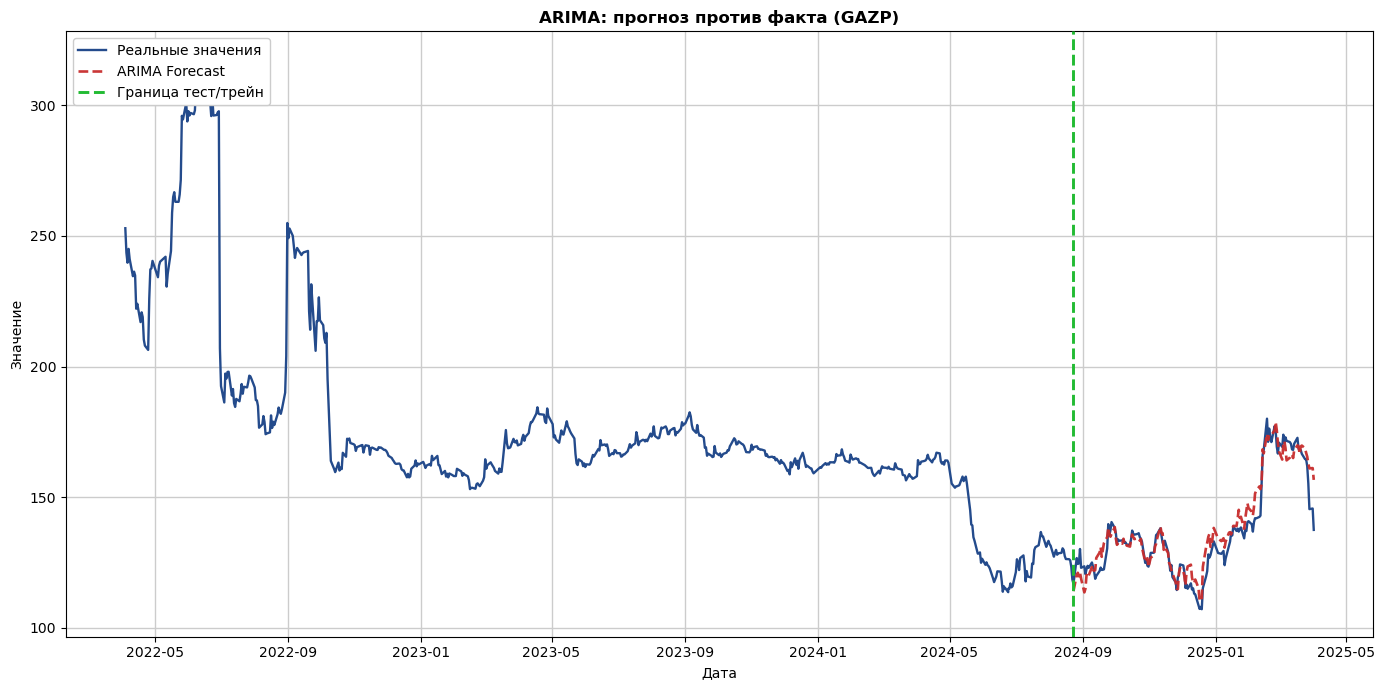

In [77]:
# Предсказание на тестовом наборе
n_test = len(X_test)
arima_forecast = np.exp(final_arima_model.forecast(steps=n_test, 
                                            exog=X_test[model_features_arima].values
                                           ))


plot_forecast_with_dates(
    y_train=y_original_train.values,
    y_test=y_original_test.values,
    forecast=arima_forecast,
    df=df,
    title="ARIMA: прогноз против факта (GAZP)",
    label="ARIMA Forecast"
)

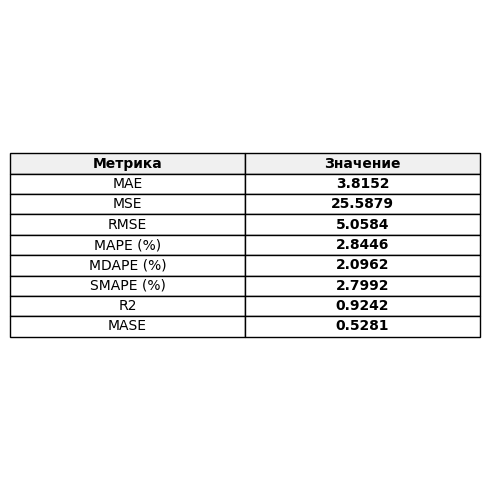

Метрика  Значение
0        MAE     3.815
1        MSE    25.588
2       RMSE     5.058
3   MAPE (%)     2.845
4  MDAPE (%)     2.096
5  SMAPE (%)     2.799
6         R2     0.924
7       MASE     0.528

In [78]:
metrics_report(y_true=y_original_test, y_pred=arima_forecast, seasonality=6)

## ВАЛИДАЦИИ

ROC AUC: 0.9704


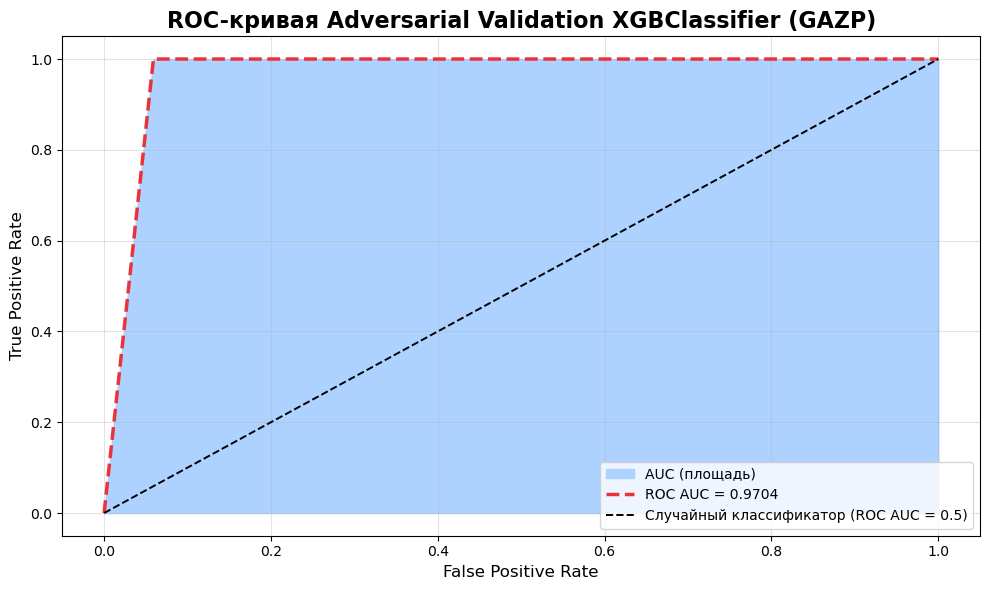

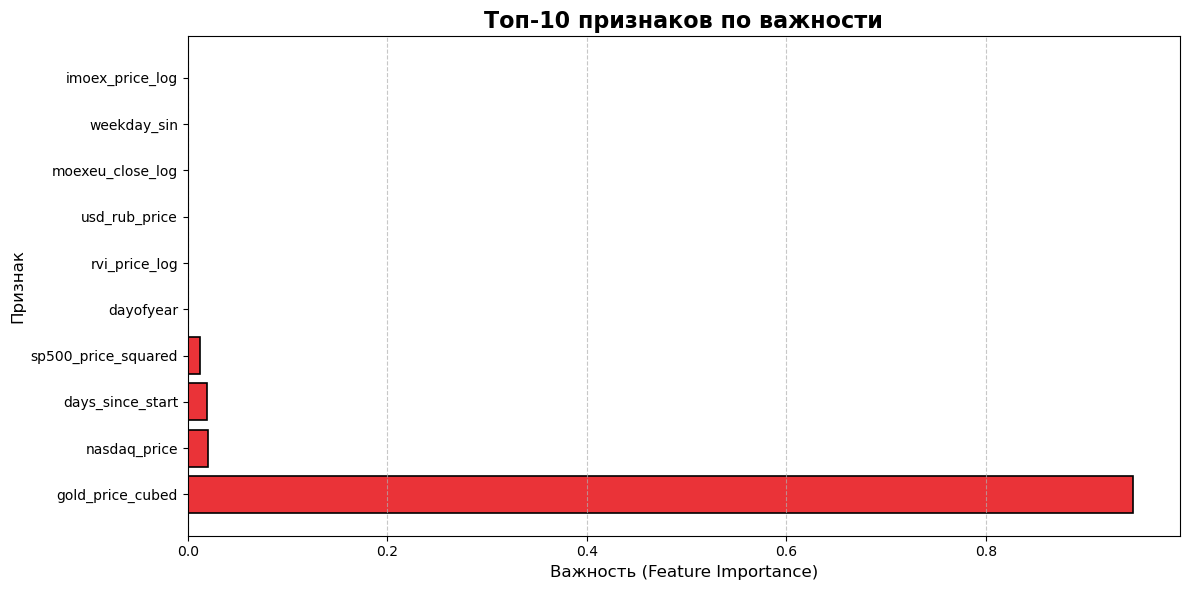

In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve

def adversarial_validation(X_train, X_test, test_size=0.3, random_state=42):
    """
    Adversarial validation между X_train и X_test с визуализацией ROC-кривой и важности признаков.
    """

    # Преобразования
    X_train = X_train.to_frame() if isinstance(X_train, pd.Series) else X_train
    X_test = X_test.to_frame() if isinstance(X_test, pd.Series) else X_test

    # Проверки
    if set(X_train.columns) != set(X_test.columns):
        raise ValueError("Колонки X_train и X_test должны совпадать")
    if any(not np.issubdtype(X_train[col].dtype, np.number) for col in X_train.columns):
        raise ValueError("Все признаки должны быть числовыми")

    # Собираем общий датафрейм и метки
    X_combined = pd.concat([X_train, X_test], axis=0)
    y_combined = np.array([0] * len(X_train) + [1] * len(X_test))

    # Индексы для разбиения (temporal split)
    train_idx = np.where(y_combined == 0)[0]
    test_idx = np.where(y_combined == 1)[0]

    split_train = int(len(train_idx) * 0.7)
    split_test = int(len(test_idx) * 0.7)

    train_part_idx = np.concatenate([train_idx[:split_train], test_idx[:split_test]])
    val_part_idx = np.concatenate([train_idx[split_train:], test_idx[split_test:]])

    X_dev, y_dev = X_combined.iloc[train_part_idx], y_combined[train_part_idx]
    X_val, y_val = X_combined.iloc[val_part_idx], y_combined[val_part_idx]

    # Модель
    model = XGBClassifier(
        max_depth=3,
        learning_rate=0.1,
        n_estimators=100,
        objective='binary:logistic',
        random_state=random_state,
        base_score=0.5
    )

    model.fit(X_dev, y_dev)
    y_pred = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)

    print(f"ROC AUC: {auc:.4f}")

    # ROC-кривая с заливкой площади
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    plt.figure(figsize=(10, 6))
    plt.fill_between(fpr, tpr, 0, color='#ADD2FF', label='AUC (площадь)')
    plt.plot(fpr, tpr, color='#EA3338', linewidth=2.5, linestyle='--', label=f'ROC AUC = {auc:.4f}')
    plt.plot([0, 1], [0, 1], 'k--', linewidth=1.4, label='Случайный классификатор (ROC AUC = 0.5)')
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC-кривая Adversarial Validation XGBClassifier (GAZP)', fontsize=16, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.35)
    plt.tight_layout()
    plt.show()

    # Важность признаков - сплошная заливка, черный контур
    feature_importance = pd.DataFrame({
        'Признак': X_combined.columns,
        'Важность': model.feature_importances_
    }).sort_values('Важность', ascending=False)

    plt.figure(figsize=(12, 6))
    bars = plt.barh(
        feature_importance['Признак'].head(10)[::-1], 
        feature_importance['Важность'].head(10)[::-1], 
        color='#EA3338',
        edgecolor='black',
        linewidth=1.2
    )
    # Топ-1 выделяем голубым (в конце, т.к. plot обратный)
    if len(bars) > 0:
        bars[0].set_color('#ADD2FF')
    plt.title('Топ-10 признаков по важности', fontsize=16, fontweight='bold')
    plt.xlabel('Важность (Feature Importance)', fontsize=12)
    plt.ylabel('Признак', fontsize=12)
    plt.gca().invert_yaxis()
    plt.grid(True, linestyle='--', alpha=0.7, axis='x')
    plt.tight_layout()
    plt.show()

    return auc, feature_importance

auc, feature_importance = adversarial_validation(
    X_train=X_train[model_features_arima],
    X_test=X_test[model_features_arima]
)

In [81]:
def kolmogorov_smirnov_target_analysis(
    train_y, test_y, bins=30, 
    target_name='IMOEX',
    plot_type='kde',
    xlabel='Значения',
    ylabel='Плотность'
):
    """
    KS-анализ с поддержкой кастомных названий и подписей осей.
    """

    arr_train = train_y.dropna().values
    arr_test = test_y.dropna().values

    if len(arr_train) == 0 or len(arr_test) == 0:
        print("Ошибка: train или test содержит пустой массив.")
        return

    train_sorted = np.sort(arr_train)
    test_sorted = np.sort(arr_test)

    # 1. Плотность или гистограмма
    plt.figure(figsize=(12, 5))
    if plot_type == 'kde':
        sns.kdeplot(arr_train, label='Train: распределение таргета', fill=True, color='#EA3338', alpha=0.4)
        sns.kdeplot(arr_test, label='Test: распределение таргета', fill=True, color='#ADD2FF', alpha=0.4)
        plt.title(f'Диаграмма плотности (KDE) таргета ({target_name})', fontsize=14, fontweight='bold')
    else:
        bins_range = np.linspace(min(arr_train.min(), arr_test.min()), max(arr_train.max(), arr_test.max()), bins + 1)
        plt.hist(arr_train, bins=bins_range, alpha=0.5, label='Train: распределение таргета', density=True, color='#EA3338')
        plt.hist(arr_test, bins=bins_range, alpha=0.5, label='Test: распределение таргета', density=True, color='#ADD2FF')
        plt.title(f'Гистограмма распределения таргета ({target_name})', fontsize=14, fontweight='bold')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 2. ECDF
    plt.figure(figsize=(12, 5))
    plt.plot(train_sorted, np.arange(1, len(train_sorted) + 1) / len(train_sorted), label='Train: ECDF', color='#EA3338')
    plt.plot(test_sorted, np.arange(1, len(test_sorted) + 1) / len(test_sorted), label='Test: ECDF', color='#ADD2FF')
    plt.title(f'Эмпирические функции распределения (ECDF) таргета ({target_name})', fontsize=14, fontweight='bold')
    plt.xlabel(xlabel)
    plt.ylabel('Доля наблюдений')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 3. Приведённые распределения
    train_to_test = np.searchsorted(train_sorted, test_sorted) / len(train_sorted)
    test_ecdf = np.arange(1, len(test_sorted) + 1) / len(test_sorted)
    ks_diff = np.abs(train_to_test - test_ecdf)
    ks_stat_idx = np.argmax(ks_diff)
    ks_stat = ks_diff[ks_stat_idx]
    x_ks = test_sorted[ks_stat_idx]

    ks_result = ks_2samp(arr_train, arr_test)

    legend_lines = [
        'Train: ECDF в точках Test',
        'Test: ECDF',
        f'KS-статистика = {ks_stat:.4f}',
        f'p-value: {ks_result.pvalue:.4f}'
    ]

    plt.figure(figsize=(12, 5))
    plt.plot(test_sorted, train_to_test, color='#EA3338')
    plt.plot(test_sorted, test_ecdf, color='#ADD2FF')
    plt.vlines(
        x_ks,
        ymin=test_ecdf[ks_stat_idx],
        ymax=train_to_test[ks_stat_idx],
        color='black', linestyle='--', linewidth=2
    )
    y_text = (train_to_test[ks_stat_idx] + test_ecdf[ks_stat_idx]) / 2
    plt.text(x_ks, y_text, f"{ks_stat:.4f}", fontsize=10, color='black')
    plt.title(f'KS-тест и приведённые ECDF для таргета ({target_name})', fontsize=14, fontweight='bold')
    plt.xlabel(xlabel)
    plt.ylabel('ECDF / Доля наблюдений')

    from matplotlib.lines import Line2D
    custom_lines = [
        Line2D([0], [0], color='#EA3338', lw=2),
        Line2D([0], [0], color='#ADD2FF', lw=2),
        Line2D([0], [0], color='black', lw=2, linestyle='--'),
        Line2D([0], [0], color='white', lw=0)
    ]
    plt.legend(custom_lines, legend_lines, loc='upper left', frameon=True)

    plt.grid(True)
    plt.tight_layout()
    plt.show()

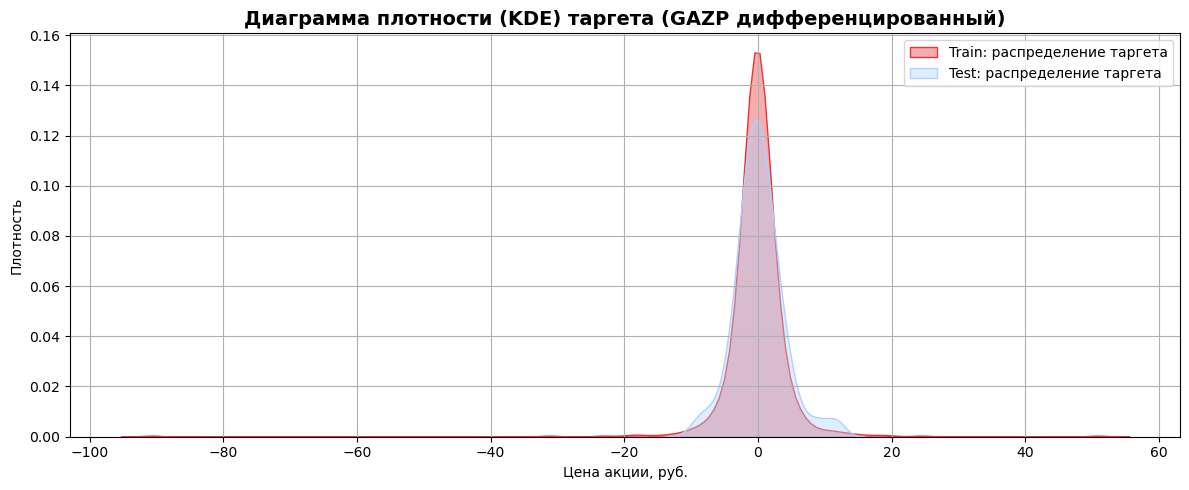

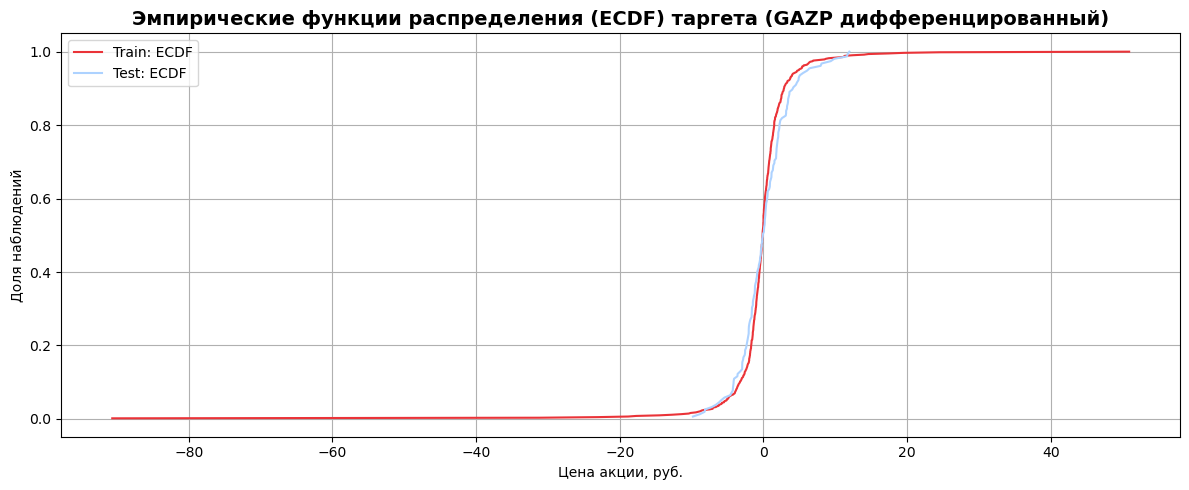

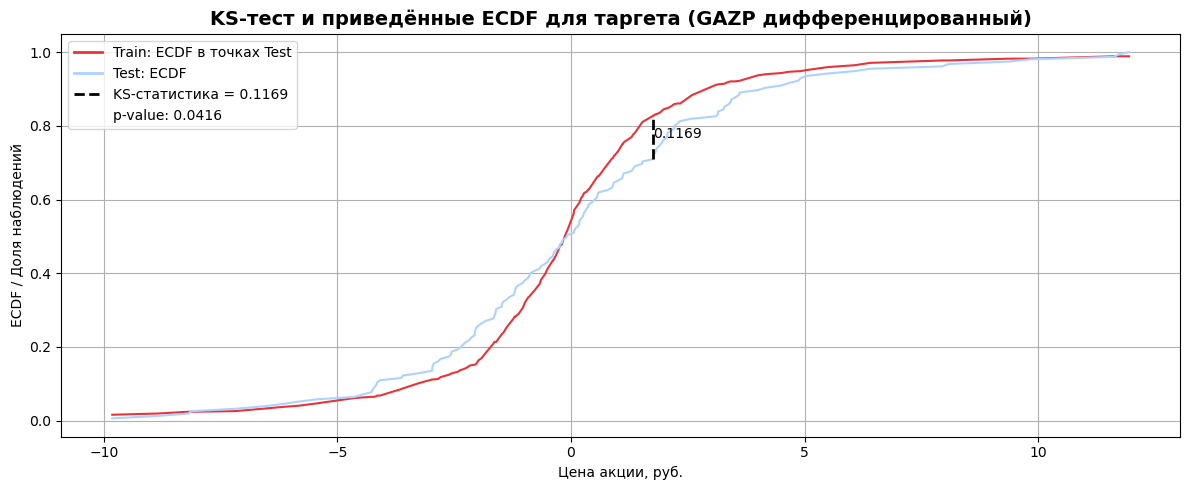

In [211]:
kolmogorov_smirnov_target_analysis(
    train_y=y_train, 
    test_y=y_test,
    bins=40,
    target_name='GAZP дифференцированный',
    xlabel='Цена акции, руб.',
    ylabel='Плотность'
)

In [207]:
def format_ks_test_results(sample1, sample2, name='таргета (name)'):
    """
    Выполняет тест Колмогорова–Смирнова (двусторонний, less, greater),
    формирует и выводит таблицу с результатами в нужном стиле.

    Аргументы:
        sample1: первая выборка
        sample2: вторая выборка
        name: имя переменной для отображения

    Возвращает:
        DataFrame с округлёнными результатами.
    """
    ks_result = ks_2samp(sample1, sample2, alternative='two-sided')
    ks_less = ks_2samp(sample1, sample2, alternative='less')
    ks_greater = ks_2samp(sample1, sample2, alternative='greater')

    df = pd.DataFrame({
        'Метрика': [
            'KS-статистика (двусторонний тест)',
            'KS-статистика (альтернатива: less)',
            'KS-статистика (альтернатива: greater)',
            'p-value (двусторонний тест)'
        ],
        'Значение': [
            f"{ks_result.statistic:.4f}",
            f"{ks_less.statistic:.4f}",
            f"{ks_greater.statistic:.4f}",
            f"{ks_result.pvalue:.4f}"
        ]
    })

    print(f"\nРезультаты KS-теста для {name}:\n")
    print(df.to_markdown(index=False, tablefmt="grid", colalign=("left", "right")))

    return df

format_ks_test_results(y_train, y_test, name='таргета (GAZP дифференцированный)')


Результаты KS-теста для таргета (GAZP дифференцированный):

+---------------------------------------+------------+
| Метрика                               |   Значение |
+=======================================+============+
| KS-статистика (двусторонний тест)     |     0.1234 |
+---------------------------------------+------------+
| KS-статистика (альтернатива: less)    |      0.096 |
+---------------------------------------+------------+
| KS-статистика (альтернатива: greater) |     0.1234 |
+---------------------------------------+------------+
| p-value (двусторонний тест)           |     0.0416 |
+---------------------------------------+------------+


Метрика Значение
0      KS-статистика (двусторонний тест)   0.1234
1     KS-статистика (альтернатива: less)   0.0960
2  KS-статистика (альтернатива: greater)   0.1234
3            p-value (двусторонний тест)   0.0416

## Теперь будем анализировать прогнозы!

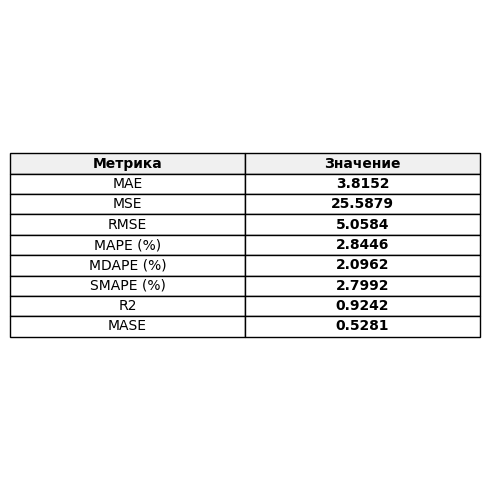

Метрика  Значение
0        MAE     3.815
1        MSE    25.588
2       RMSE     5.058
3   MAPE (%)     2.845
4  MDAPE (%)     2.096
5  SMAPE (%)     2.799
6         R2     0.924
7       MASE     0.528

In [85]:
metrics_report(y_true=y_original_test, y_pred=arima_forecast, seasonality=6, model_name='ARIMA')

### Бутстрап-интервал + гистограмма

### ARIMA

In [88]:
def bootstrap_rmse_hist_ci(
    y_true, y_pred, n_iterations=10000, alpha=0.05, bins=30, title="Бутстрэп RMSE: 95% доверительный интервал"
):
    """
    Бутстрэп-распределение RMSE с гистограммой и плотностью в фирменных цветах.
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    assert len(y_true) == len(y_pred), "Длины массивов должны совпадать"
    n = len(y_true)
    rmses = []
    for _ in range(n_iterations):
        idx = np.random.choice(n, size=n, replace=True)
        rmse = np.sqrt(np.mean((y_true[idx] - y_pred[idx])**2))
        rmses.append(rmse)
    rmses = np.array(rmses)
    
    # Границы бутстрэп-интервала
    left = np.percentile(rmses, 100 * alpha / 2)
    right = np.percentile(rmses, 100 * (1 - alpha / 2))
    median = np.median(rmses)
    mean = np.mean(rmses)
    
    # Гистограмма
    plt.figure(figsize=(10, 5))
    counts, bin_edges, patches = plt.hist(
        rmses, bins=bins, density=True, color="#ADD2FF", alpha=0.4, edgecolor="#ADD2FF", label=None
    )
    # Окрашивание вне интервала
    for patch, left_edge, right_edge in zip(patches, bin_edges[:-1], bin_edges[1:]):
        if right_edge < left or left_edge > right:
            patch.set_facecolor('#EA3338')
            patch.set_alpha(0.4)
        else:
            patch.set_facecolor('#ADD2FF')
            patch.set_alpha(0.4)

    # Плотность KDE
    sns.kdeplot(rmses, color="#ADD2FF", fill=True, alpha=0.4, linewidth=2, label="Плотность (KDE)")
    # Нарисуем ещё контур (тонкий) для чёткости
    sns.kdeplot(rmses, color="#005CBF", fill=False, linewidth=1.3, label=None)

    # Линии: медиана, среднее, CI
    plt.axvline(median, color="#EA3338", linestyle="-", lw=2, label=f"Медиана: {median:.3f}")
    plt.axvline(mean, color="#005CBF", linestyle="--", lw=2, label=f"Среднее: {mean:.3f}")
    plt.axvline(left, color="#EA3338", linestyle="--", lw=2, label=f"Левая граница CI: {left:.3f}")
    plt.axvline(right, color="#EA3338", linestyle="--", lw=2, label=f"Правая граница CI: {right:.3f}")

    # Титул и оси
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel('RMSE')
    plt.ylabel('Плотность')
    plt.legend()
    plt.grid(True, alpha=0.2)
    plt.tight_layout()
    plt.show()
    
    print(f"Bootstrap CI: [{left:.4f}, {right:.4f}]")
    print(f"Медиана: {median:.4f}")
    print(f"Среднее: {mean:.4f}")
    return left, right, median, mean, rmses

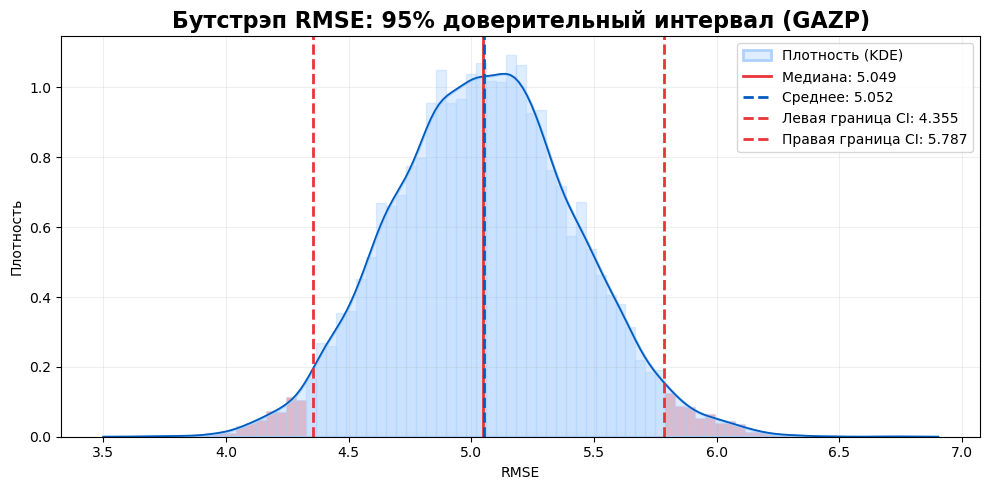

Bootstrap CI: [4.3547, 5.7869]
Медиана: 5.0487
Среднее: 5.0521


(4.354663805041748,
 5.786874336108261,
 5.0486676446447465,
 5.052133402610783,
 array([5.45537156, 4.96708267, 5.58980842, ..., 5.19681375, 5.04246949,
        4.96765129]))

In [89]:
bootstrap_rmse_hist_ci(y_true=y_original_test,  
                       y_pred=arima_forecast, 
                       n_iterations=10000,
                       alpha=0.05,
                       bins=75,
                       title="Бутстрэп RMSE: 95% доверительный интервал (GAZP)"
                      )